# Preprocessing of submitted models

## Removing selected categories of corrupted images

In [ ]:
import os
import pandas as pd

# SETUP PATHS
dataset_dir = os.path.join(current_dir, 'dataset/original_data/train_data')
csv_dir = os.path.join(current_dir, 'dataset', 'csv_to_exclude')
label_file_path = os.path.join(current_dir, 'ginger', 'train_labels_cleaned.csv')

# SELECT CSVs TO EXCLUDE
# We created a csv containing the indexes of the corrupted images for each category
csv_files_to_exclude = [
     "conflicts.csv",
     "doppie.csv",     #images containing same tissue twice
     "duplicates.csv", # here we are eliminating only one column of duplicate pairs
     "macchie_verdi.csv",
     "other.csv",
     "pennarelli.csv",
     "shrek.csv",
     "strisce.csv",
]

# --- DELETE FILES FROM DISK ---
if csv_files_to_exclude:
    print("🚀 Starting physical file removal...")
    files_deleted_count = 0

    for csv_name in csv_files_to_exclude:
        full_csv_path = os.path.join(csv_dir, csv_name)

        if os.path.exists(full_csv_path):
            # Read exclusion CSV (semicolon separated)
            df_exclude = pd.read_csv(full_csv_path, sep=';')

            # Get list of images and masks to remove
            targets = df_exclude['image'].tolist() + df_exclude['mask'].tolist()

            for filename in targets:
                file_path = os.path.join(dataset_dir, filename)
                if os.path.exists(file_path):
                    os.remove(file_path)
                    files_deleted_count += 1
                else:
                    print(f"  Warning: Could not find {filename}")
            print(f"  -> Applied {csv_name}")
        else:
            print(f"  Warning: Could not find {csv_name}")

    print(f"✅ Physical deletion complete. Removed {files_deleted_count} files.")

else:
    print("ℹ️ No CSVs selected for deletion. Skipping Step 1.")


# --- SYNC AND UPDATE THE LABEL CSV ---
print("\n🔄 Updating train_labels_cleaned.csv...")

if os.path.exists(label_file_path):
    df_labels = pd.read_csv(label_file_path, sep=',')
    initial_count = len(df_labels)
    existing_files = set(os.listdir(dataset_dir))

    # Filter the dataframe
    df_updated = df_labels[df_labels['sample_index'].isin(existing_files)]
    final_count = len(df_updated)

    # Save the updated CSV
    df_updated.to_csv(label_file_path, index=False)

    print(f"  -> Original Label Count: {initial_count}")
    print(f"  -> New Label Count:      {final_count}")
    print(f"  -> Removed {initial_count - final_count} rows from the CSV.")
    print("✅ CSV updated successfully.")
else:
    print(f" Error: Could not find {label_file_path}")

🚀 Starting physical file removal...
  -> Applied conflicts.csv
  -> Applied doppie.csv
  -> Applied duplicates.csv
  -> Applied other.csv
  -> Applied pennarelli.csv
  -> Applied strisce.csv
✅ Physical deletion complete. Removed 546 files.

🔄 Updating train_labels_cleaned.csv...
  -> Original Label Count: 1168
  -> New Label Count:      895
  -> Removed 273 rows from the CSV.
✅ CSV updated successfully.


##Tiling

### First method

Tiling 224x224 non-overlapping squares that contains at least 40% of the tissue and 5% of its white part of the mask

In [ ]:
import cv2
import numpy as np
import os
import shutil
from tqdm import tqdm
import pandas as pd

# --- CONFIGURATION ---
TILE_SIZE = 224
STRIDE = 112  # Half the tile size. This creates 50% overlap during GENERATION only.

# INPUT: Single folder containing BOTH img_*.png and mask_*.png
input_folder = 'dataset/original_data/test_data'
input_csv = None

# OUTPUT
output_base = 'dataset/tiles_double_filter_bal_test'
output_img_dir = os.path.join(output_base, 'images')
output_mask_dir = os.path.join(output_base, 'masks')

# Thresholds
MIN_TISSUE_RATIO = 0.40
MIN_MASK_RATIO = 0.05

# Setup directories
if os.path.exists(output_base):
    shutil.rmtree(output_base)
os.makedirs(output_img_dir)
os.makedirs(output_mask_dir)

# --- HELPER FUNCTIONS ---

def get_tissue_mask_hsv(img):
    """Calculates tissue area for statistics."""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturation = hsv[:, :, 1]
    _, mask = cv2.threshold(saturation, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    return mask

def is_overlapping(box1, box2, size):
    """
    Checks if two squares overlap.
    box = (x, y)
    """
    x1, y1 = box1
    x2, y2 = box2

    # If the distance between corners is less than the size, they overlap
    if abs(x1 - x2) < size and abs(y1 - y2) < size:
        return True
    return False

# --- MAIN PROCESS ---

all_files = os.listdir(input_folder)
img_files = [f for f in all_files if f.startswith('img') and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Processing {len(img_files)} images with Optimized Sliding Window...")

labels = pd.read_csv(input_csv) if input_csv is not None else None
if input_csv is not None:
    train_lens_lab = {
          "Luminal B": 0,
          "Luminal A": 0,
          "HER2(+)": 0,
          "Triple negative": 0
    }
else:
    train_lens_lab = None

for filename in tqdm(img_files):
    # 1. Load Data
    img_path = os.path.join(input_folder, filename)
    mask_filename = filename.replace("img", "mask")
    mask_path = os.path.join(input_folder, mask_filename)

    img = cv2.imread(img_path)
    if img is None: continue

    if os.path.exists(mask_path):
        gt_mask = cv2.imread(mask_path, 0)
    else:
        gt_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    tissue_mask = get_tissue_mask_hsv(img)

    # 2. GENERATE CANDIDATES (With Overlap)
    h, w, _ = img.shape
    candidates = []

    # Use smaller stride (112) to catch centered features
    for y in range(0, h - TILE_SIZE + 1, STRIDE):
        for x in range(0, w - TILE_SIZE + 1, STRIDE):

            # Crop
            tissue_patch_mask = tissue_mask[y:y+TILE_SIZE, x:x+TILE_SIZE]
            gt_patch = gt_mask[y:y+TILE_SIZE, x:x+TILE_SIZE]

            # Stats
            n_pixels = TILE_SIZE * TILE_SIZE
            tissue_pixels = np.count_nonzero(tissue_patch_mask)
            gt_pixels = np.count_nonzero(gt_patch)

            tissue_ratio = tissue_pixels / n_pixels
            mask_ratio = gt_pixels / n_pixels

            # Save metadata (Don't crop image yet to save RAM)
            candidates.append({
                'x': x,
                'y': y,
                'tissue_ratio': tissue_ratio,
                'mask_ratio': mask_ratio
            })

    # 3. FILTERING & SORTING
    # Filter: Must pass thresholds
    valid_candidates = [
        c for c in candidates
        if c['mask_ratio'] > MIN_MASK_RATIO and c['tissue_ratio'] > MIN_TISSUE_RATIO
    ]

    # Sort: Best mask coverage first, then best tissue coverage
    valid_candidates.sort(key=lambda x: (x['mask_ratio'], x['tissue_ratio']), reverse=True)

    # 4. GREEDY SELECTION (Non-Maximum Suppression)
    final_tiles = []

    tiles_created = 0
    if labels is None:
        max_tiles = 5
        lab = None
    else:
        row = labels[labels["sample_index"] == filename]
        lab = row["label"].values[0]
        if lab == "Luminal B":
            max_tiles = 1
        elif lab == "Luminal A" or lab == "HER2(+)":
            max_tiles = 2
        else:
            max_tiles = 10
    for cand in valid_candidates:
        if tiles_created >= max_tiles:
            break
        # Check if this candidate overlaps with any we have already chosen
        overlaps = False
        for chosen in final_tiles:
            if is_overlapping((cand['x'], cand['y']), (chosen['x'], chosen['y']), TILE_SIZE):
                overlaps = True
                break

        # If no overlap, we keep it (because it's the best remaining one)
        if not overlaps:
            final_tiles.append(cand)
            tiles_created += 1
            if lab is not None:
                train_lens_lab[lab] += 1

    # 5. FALLBACK
    # If logic removed everything, pick the single best raw candidate
    if len(final_tiles) == 0 and len(candidates) > 0:
        candidates.sort(key=lambda x: (x['mask_ratio'], x['tissue_ratio']), reverse=True)
        final_tiles.append(candidates[0])
        if lab is not None:
            train_lens_lab[lab] += 1

    # 6. SAVE
    base_name = os.path.splitext(filename)[0]

    for i, meta in enumerate(final_tiles):
        x, y = meta['x'], meta['y']

        # Do the actual crop now
        img_patch = img[y:y+TILE_SIZE, x:x+TILE_SIZE]
        mask_patch = gt_mask[y:y+TILE_SIZE, x:x+TILE_SIZE]

        save_img_name = f"{base_name}_t{i}.png"
        save_mask_name = save_img_name.replace("img", "mask")

        cv2.imwrite(os.path.join(output_img_dir, save_img_name), img_patch)
        cv2.imwrite(os.path.join(output_mask_dir, save_mask_name), mask_patch)

print("Processing Complete.")
print(f"Images saved to: {output_img_dir}")
print(f"Masks saved to:  {output_mask_dir}")
if train_lens_lab is not None:
    print(f"Label Distribution: {train_lens_lab}")

Processing 477 images with Optimized Sliding Window...


100%|██████████| 477/477 [01:12<00:00,  6.56it/s]

Processing Complete.
Images saved to: dataset/tiles_double_filter_bal_test/images
Masks saved to:  dataset/tiles_double_filter_bal_test/masks


### Second method

extracting 224x224 tiles, taking for each image one tile in the most white-pixel dense area of the mask and other 4 tiles which are adjacent to the initial one.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_best_density_center(mask, target_size=224):
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    density_map = cv2.boxFilter(mask, cv2.CV_32F, (target_size, target_size), normalize=False)

    _, max_val, _, max_loc = cv2.minMaxLoc(density_map)
    center_x, center_y = max_loc

    if max_val == 0:
        h, w = mask.shape[:2]
        center_x, center_y = w // 2, h // 2

    return center_x, center_y

def crop_from_center(image, mask, center_x, center_y, target_size=224, shift=(0,0)):
    h, w = image.shape[:2]

    start_x = center_x + shift[0] - (target_size // 2)
    start_y = center_y + shift[1] - (target_size // 2)

    start_x = max(0, min(start_x, w - target_size))
    start_y = max(0, min(start_y, h - target_size))

    img_cropped = image[start_y : start_y + target_size, start_x : start_x + target_size]
    mask_cropped = mask[start_y : start_y + target_size, start_x : start_x + target_size]

    return img_cropped, mask_cropped

def pad_if_needed(image, mask, target_size=224):
    h, w = image.shape[:2]
    pad_h = max(0, target_size - h)
    pad_w = max(0, target_size - w)

    if pad_h > 0 or pad_w > 0:
        image = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)
        mask = cv2.copyMakeBorder(mask, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)

    return image, mask

def create_augmented_smart_patches(source_train_dir, source_test_dir, target_dir, size=224, shift_amount=32):
    # Crea cartelle
    os.makedirs(target_dir + "/train_data", exist_ok=True)
    os.makedirs(target_dir + "/test_data", exist_ok=True)

    # --- 1. PREPARAZIONE ETICHETTE ---
    # Dobbiamo sapere la classe di ogni immagine per assegnarla alle 5 varianti.
    # Creiamo un dizionario veloce: "img_0009.png" -> "Luminal A"
    print("Loading labels...")
    original_df = pd.read_csv(source_train_dir + "/train_labels.csv")

    # Pulisce spazi bianchi dai nomi colonne
    original_df.columns = [c.strip() for c in original_df.columns]

    # Mappa: Nome File -> Label
    # Assumiamo che sample_index contenga il nome file esatto (es. "img_0009.png")
    filename_to_label = dict(zip(original_df['sample_index'], original_df['label']))

    new_labels = []

    shifts = [
        (0, 0, "_C"),
        (0, -shift_amount, "_U"),
        (0, shift_amount, "_D"),
        (-shift_amount, 0, "_L"),
        (shift_amount, 0, "_R")
    ]

    # --- 2. PROCESSING TRAIN DATA (Iterando sui FILE) ---
    print("Processing Train Data...")
    train_files = os.listdir(source_train_dir + "/train_data")

    for filename in tqdm(train_files):
        if "mask" in filename:
            continue

        # Verifica se abbiamo l'etichetta per questo file
        if filename not in filename_to_label:
            # Se il CSV ha "100" ma il file è "img_00100.png", qui potrebbe fallire.
            # Ma se il CSV ha "img_0009.png", funzionerà perfettamente.
            print(f"Skipping {filename} (Label not found in CSV)")
            continue

        label = filename_to_label[filename]

        image = cv2.imread(source_train_dir + "/train_data/" + filename)
        maskname = filename.replace("img", "mask")
        mask = cv2.imread(source_train_dir + "/train_data/" + maskname)

        if image is None or mask is None: continue

        image, mask = pad_if_needed(image, mask, size)
        cx, cy = get_best_density_center(mask, size)

        # Estrai nome base ed estensione (es. "img_0009", ".png")
        basename, ext = os.path.splitext(filename)

        for dx, dy, suffix in shifts:
            img_crop, mask_crop = crop_from_center(image, mask, cx, cy, size, (dx, dy))

            # Crea nuovi nomi: img_0009_C.png
            new_filename = f"{basename}{suffix}{ext}"
            new_maskname = new_filename.replace("img", "mask") # img_0009_C.png -> mask_0009_C.png

            cv2.imwrite(target_dir + "/train_data/" + new_filename, img_crop)
            cv2.imwrite(target_dir + "/train_data/" + new_maskname, mask_crop)

            new_labels.append({
                'sample_index': new_filename, # Nel CSV mettiamo il nome file completo
                'label': label
            })

    # Salva il nuovo CSV ricostruito
    df_new = pd.DataFrame(new_labels)
    df_new.to_csv(target_dir + "/train_labels.csv", index=False)
    print(f"Train augmented CSV saved with {len(df_new)} rows.")

    # --- 3. PROCESSING TEST DATA ---
    print("Processing Test Data...")
    if os.path.exists(source_test_dir + "/test_data"):
        test_files = os.listdir(source_test_dir + "/test_data")
        for filename in tqdm(test_files):
            if "mask" in filename:
                continue

            image = cv2.imread(source_test_dir + "/test_data/" + filename)
            maskname = filename.replace("img", "mask")
            mask = cv2.imread(source_test_dir + "/test_data/" + maskname)

            if image is None: continue
            if mask is None: mask = np.zeros(image.shape[:2], dtype=np.uint8)

            image, mask = pad_if_needed(image, mask, size)
            cx, cy = get_best_density_center(mask, size)

            # Solo crop centrale per il test
            img_crop, mask_crop = crop_from_center(image, mask, cx, cy, size, (0,0))

            cv2.imwrite(target_dir + "/test_data/" + filename, img_crop)
            cv2.imwrite(target_dir + "/test_data/" + maskname, mask_crop)

create_augmented_smart_patches("dataset/clean_data", "dataset/original_data", "dataset/clean_aug_patches", 224, shift_amount=32)

Loading labels...
Processing Train Data...


100%|██████████| 1114/1114 [02:01<00:00,  9.20it/s]


Train augmented CSV saved with 2785 rows.
Processing Test Data...


100%|██████████| 954/954 [00:39<00:00, 24.11it/s]


# Other preprocessing experiments

## Adding manually restored images (only for initial dataset)

In [ ]:
import os
import shutil
import pandas as pd

# 1. SETUP PATHS
# Base paths
restored_base_dir = os.path.join(current_dir, 'dataset', 'restored_data')
dest_dir = os.path.join(current_dir, 'ginger', 'no_shrek_no_macchie')

# CSV paths
master_label_path = os.path.join(current_dir, 'dataset', 'train_labels.csv')
cleaned_label_path = os.path.join(current_dir, 'ginger', 'train_labels_cleaned.csv')

# 2. SELECT FOLDERS TO RESTORE
# Uncomment the folder names you want to add back to the dataset.
folders_to_restore = [
    "striscia_nera",
    "pennarello",
    "macchie_verdi",
    "doppie",
]

# --- STEP 1: RESTORE FILES ---
print("🚀 Starting Restoration Process...")

if folders_to_restore:
    total_restored = 0

    for folder_name in folders_to_restore:
        # Construct paths to the 'img' and 'mask' subfolders
        source_img_dir = os.path.join(restored_base_dir, folder_name, 'img')
        source_mask_dir = os.path.join(restored_base_dir, folder_name, 'mask')

        folder_count = 0

        # Helper function to copy files from a specific subfolder
        def copy_files(src_folder, dst_folder):
            count = 0
            if os.path.exists(src_folder):
                for filename in os.listdir(src_folder):
                    src_file = os.path.join(src_folder, filename)
                    dst_file = os.path.join(dst_folder, filename)

                    # Only copy if it's a file
                    if os.path.isfile(src_file):
                        shutil.copy2(src_file, dst_file)
                        count += 1
            return count

        # Copy Images
        imgs_moved = copy_files(source_img_dir, dest_dir)

        # Copy Masks
        masks_moved = copy_files(source_mask_dir, dest_dir)

        total_in_folder = imgs_moved + masks_moved
        total_restored += total_in_folder

        print(f"  ✅ Restored '{folder_name}': {imgs_moved} images, {masks_moved} masks.")

    print(f"\n📦 Total files restored: {total_restored}")

else:
    print("ℹ️ No folders selected. Skipping file copy.")


# --- STEP 2: UPDATE CSV LABELS ---
print("\n🔄 Updating train_labels_cleaned.csv...")

if os.path.exists(master_label_path):
    df_master = pd.read_csv(master_label_path, sep=',')
    current_files_in_dataset = set(os.listdir(dest_dir))
    df_new_cleaned = df_master[df_master['sample_index'].isin(current_files_in_dataset)]

    # 4. Save the updated CSV
    df_new_cleaned.to_csv(cleaned_label_path, index=False)

    print(f"  -> Scanned destination folder: {dest_dir}")
    print(f"  -> Matches found in master CSV: {len(df_new_cleaned)}")
    print(f"  -> Saved updated CSV to: {cleaned_label_path}")
    print("✅ CSV update complete.")

else:
    print(f"❌ Error: Could not find original master CSV at {master_label_path}")

🚀 Starting Restoration Process...
  ✅ Restored 'striscia_nera': 16 images, 16 masks.
  ✅ Restored 'pennarello': 12 images, 12 masks.
  ✅ Restored 'macchie_verdi': 14 images, 14 masks.
  ✅ Restored 'doppie': 22 images, 22 masks.

📦 Total files restored: 128

🔄 Updating train_labels_cleaned.csv...
  -> Scanned destination folder: /gdrive/My Drive/ANN-2ndChallenge/ginger/no_shrek_no_macchie
  -> Matches found in master CSV: 958
  -> Saved updated CSV to: /gdrive/My Drive/ANN-2ndChallenge/ginger/train_labels_cleaned.csv
✅ CSV update complete.


## Mask application to original images with bridging and morphological dilation

Found 958 images. Showing first 10 examples...


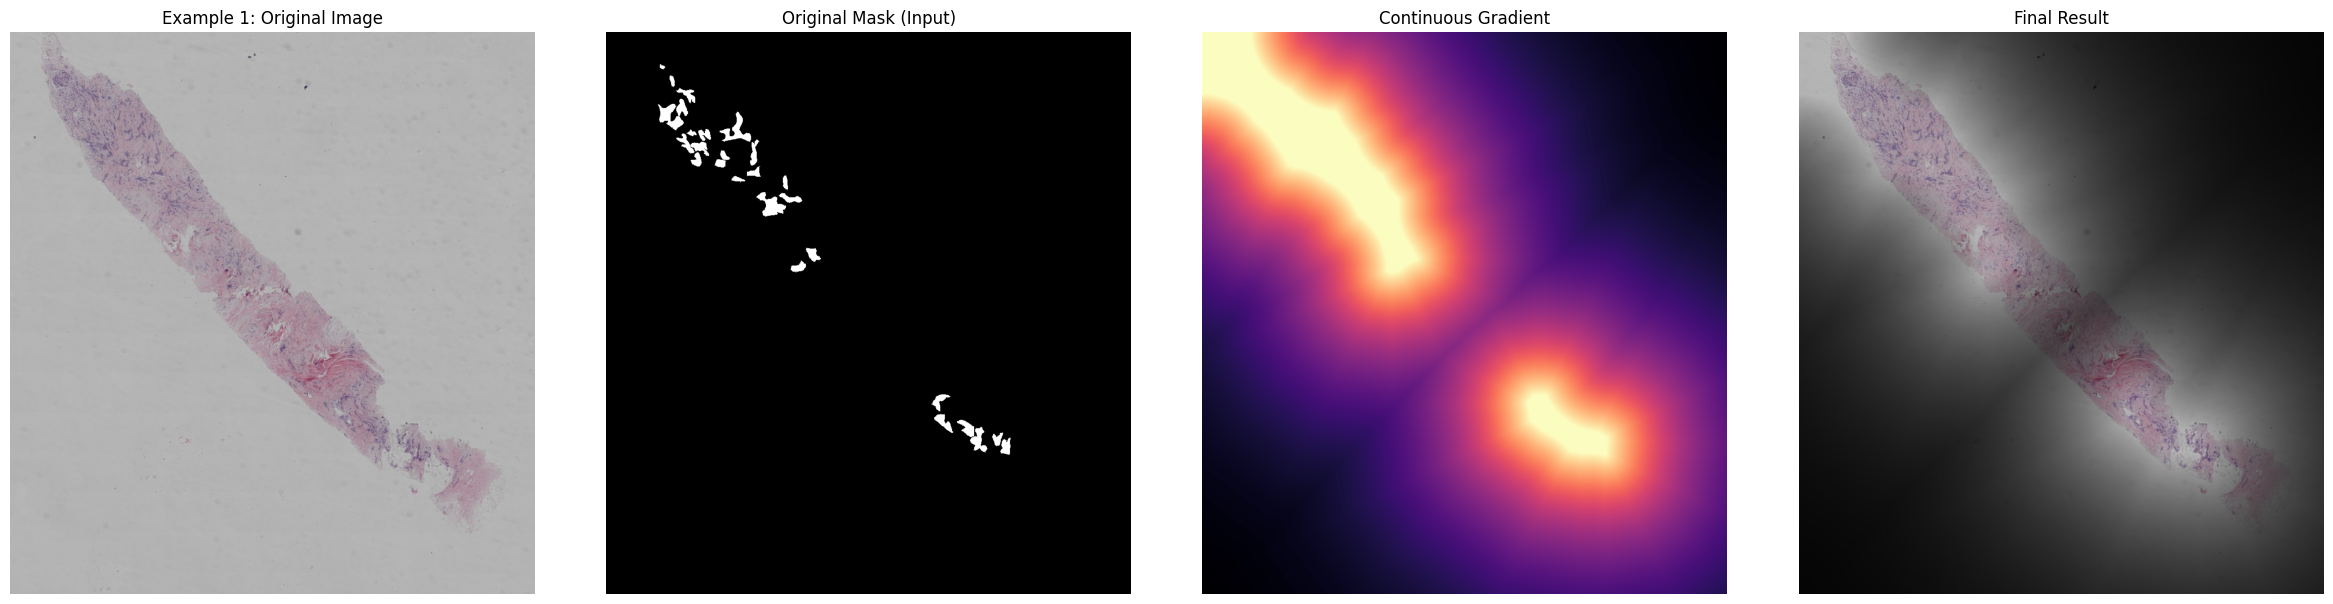

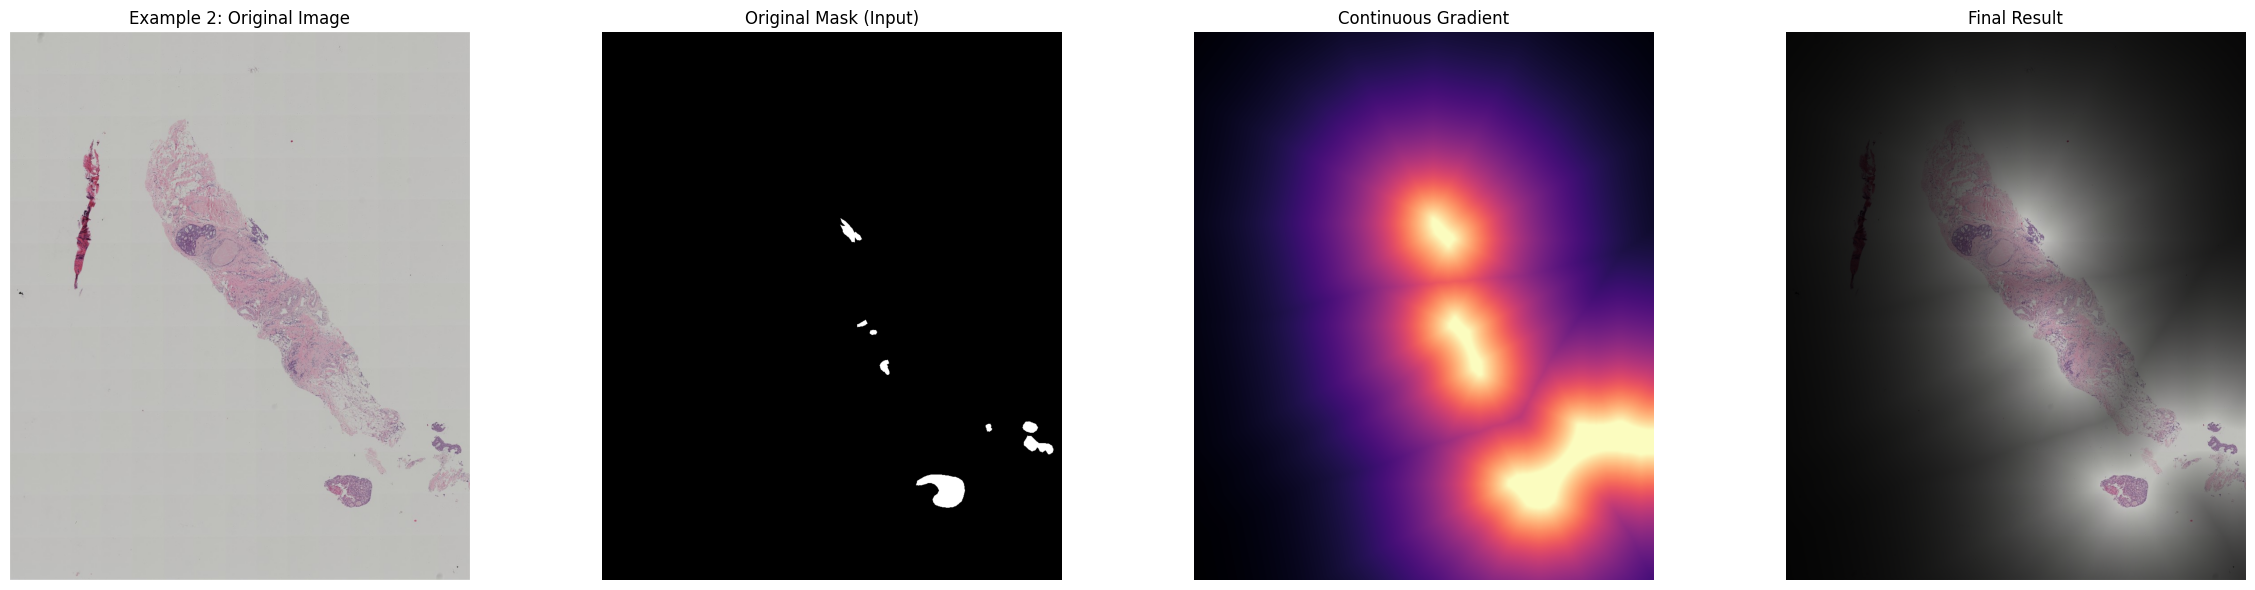

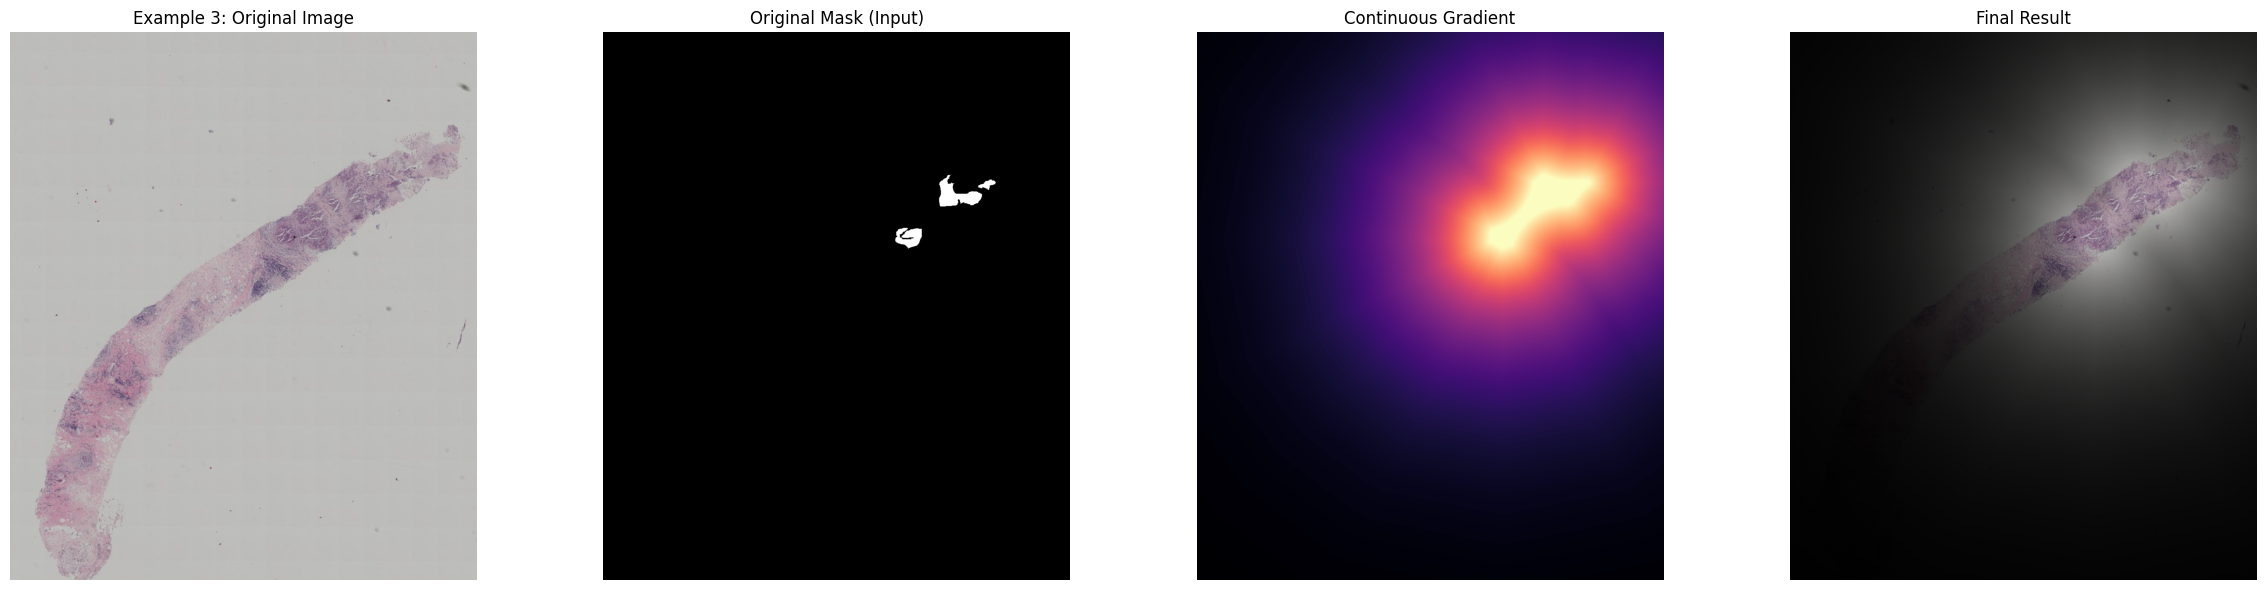

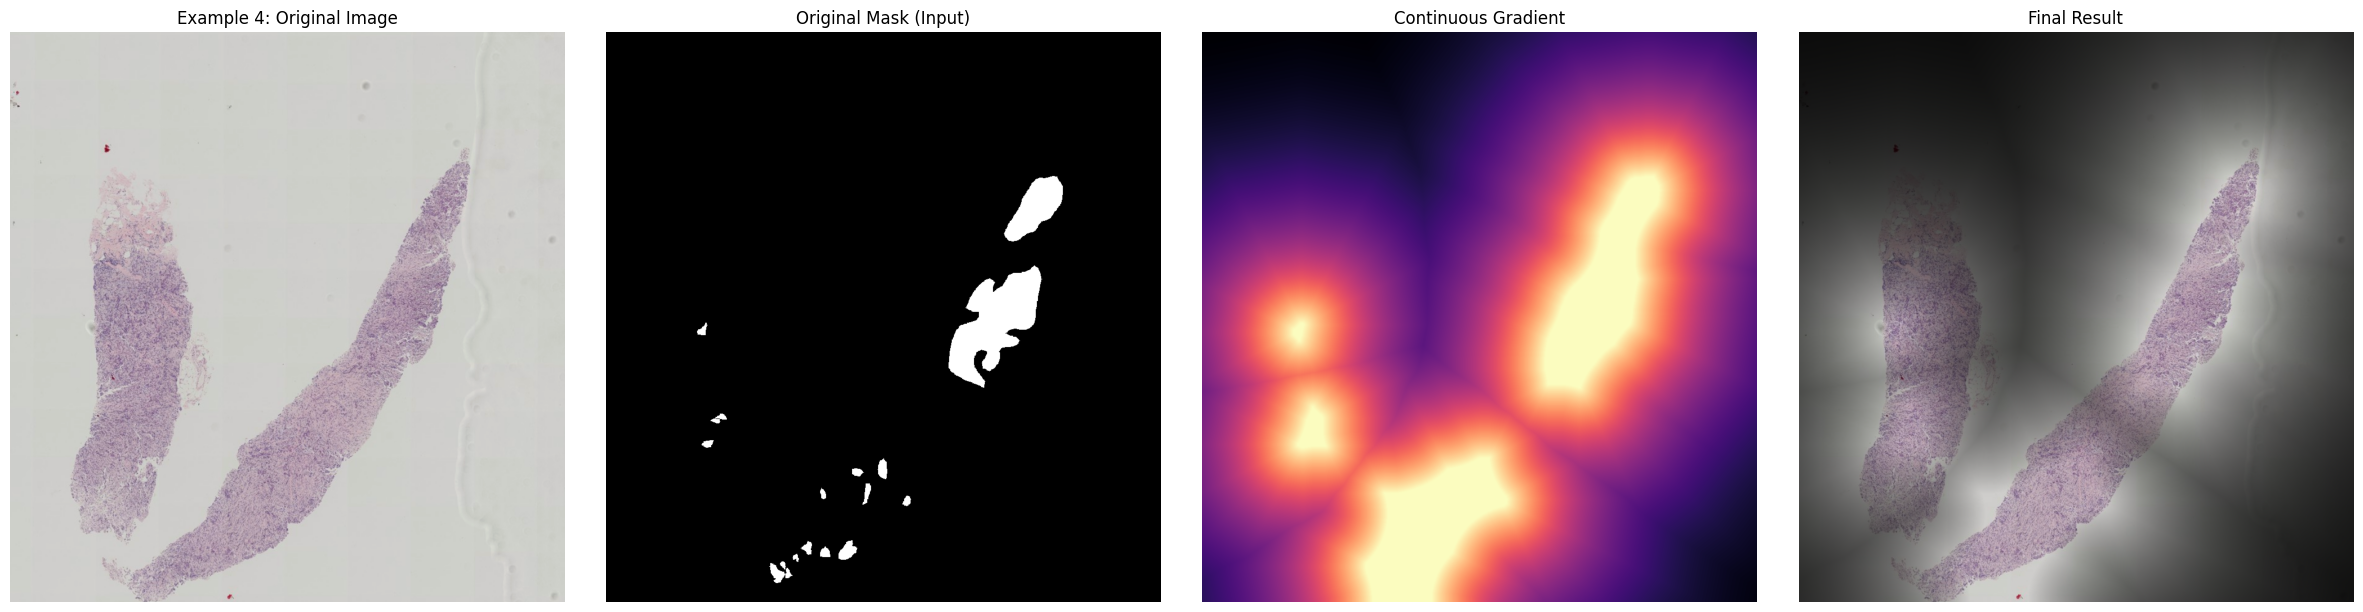

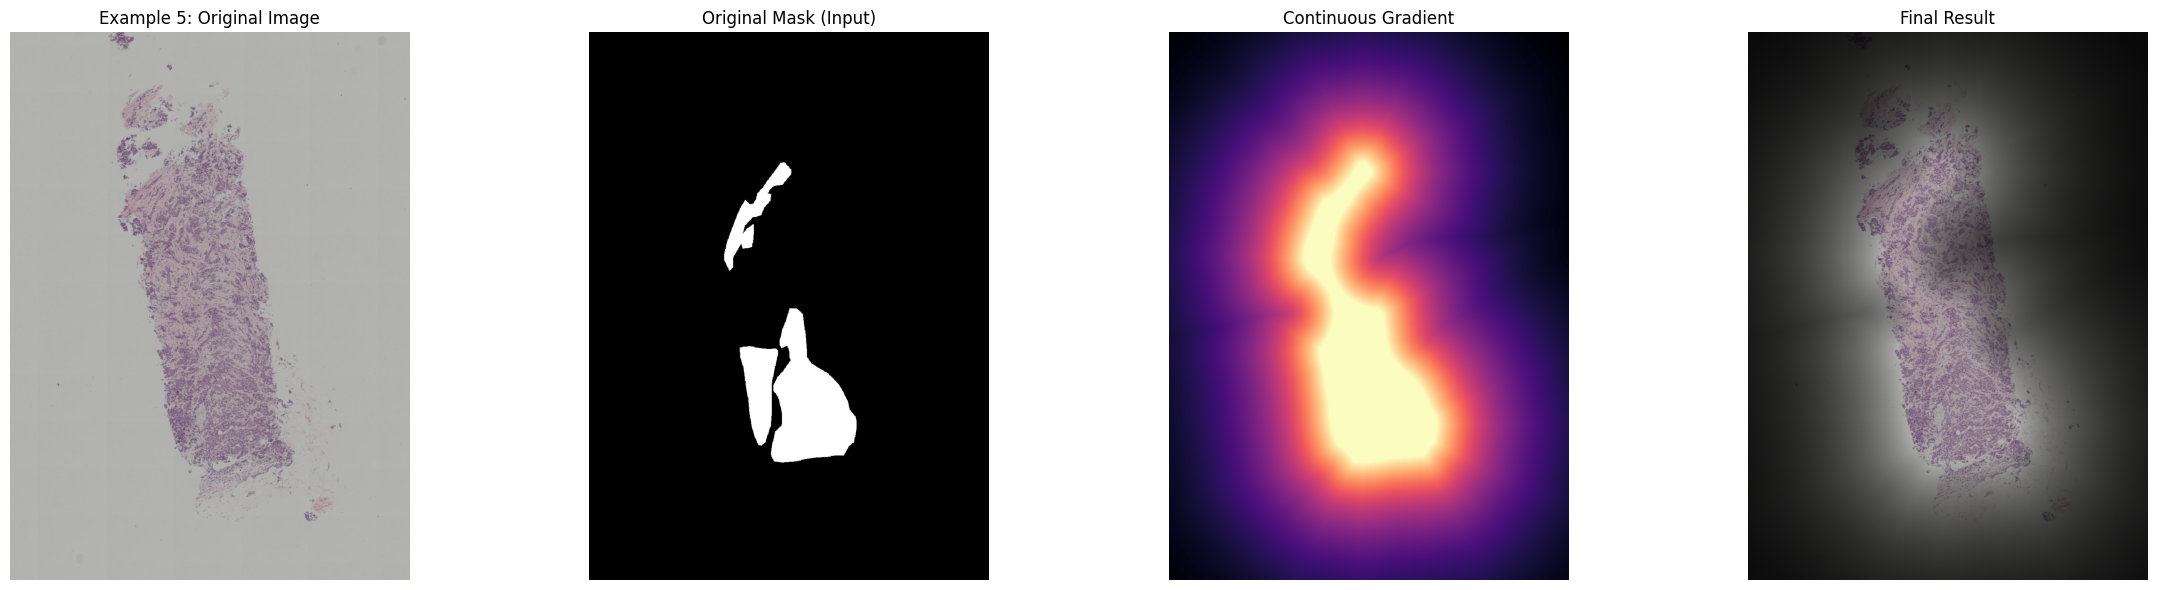

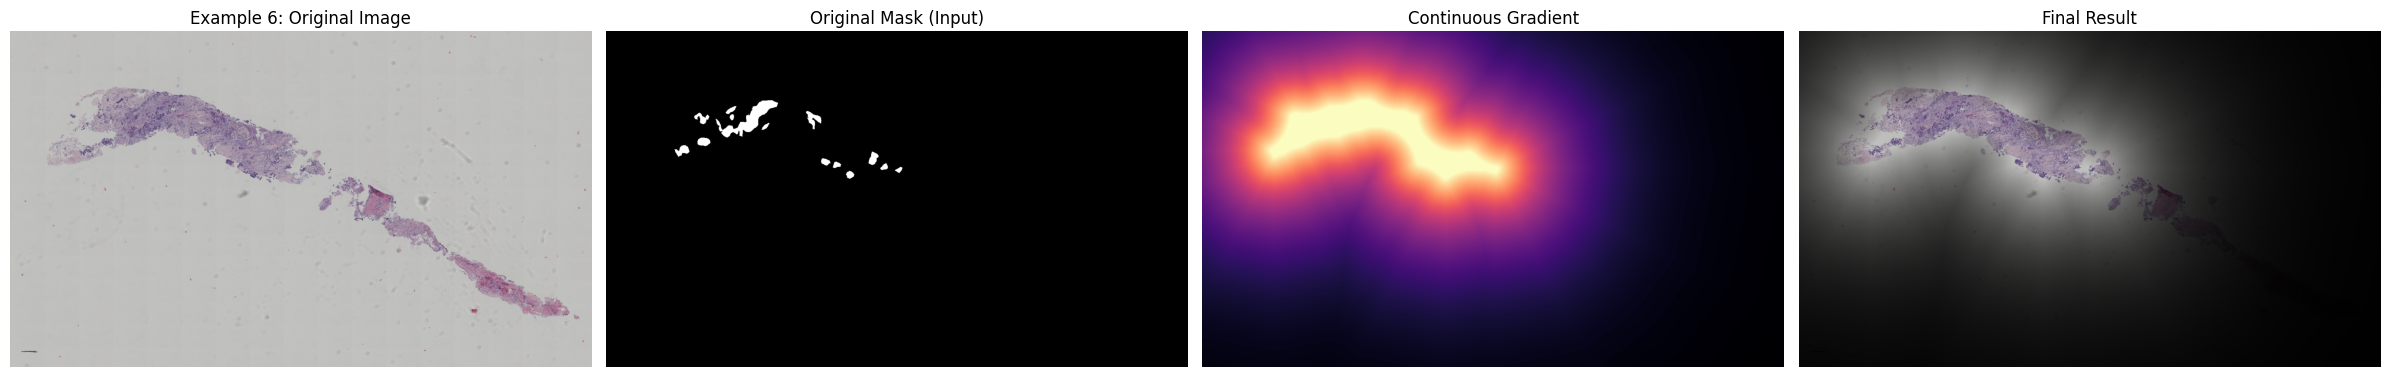

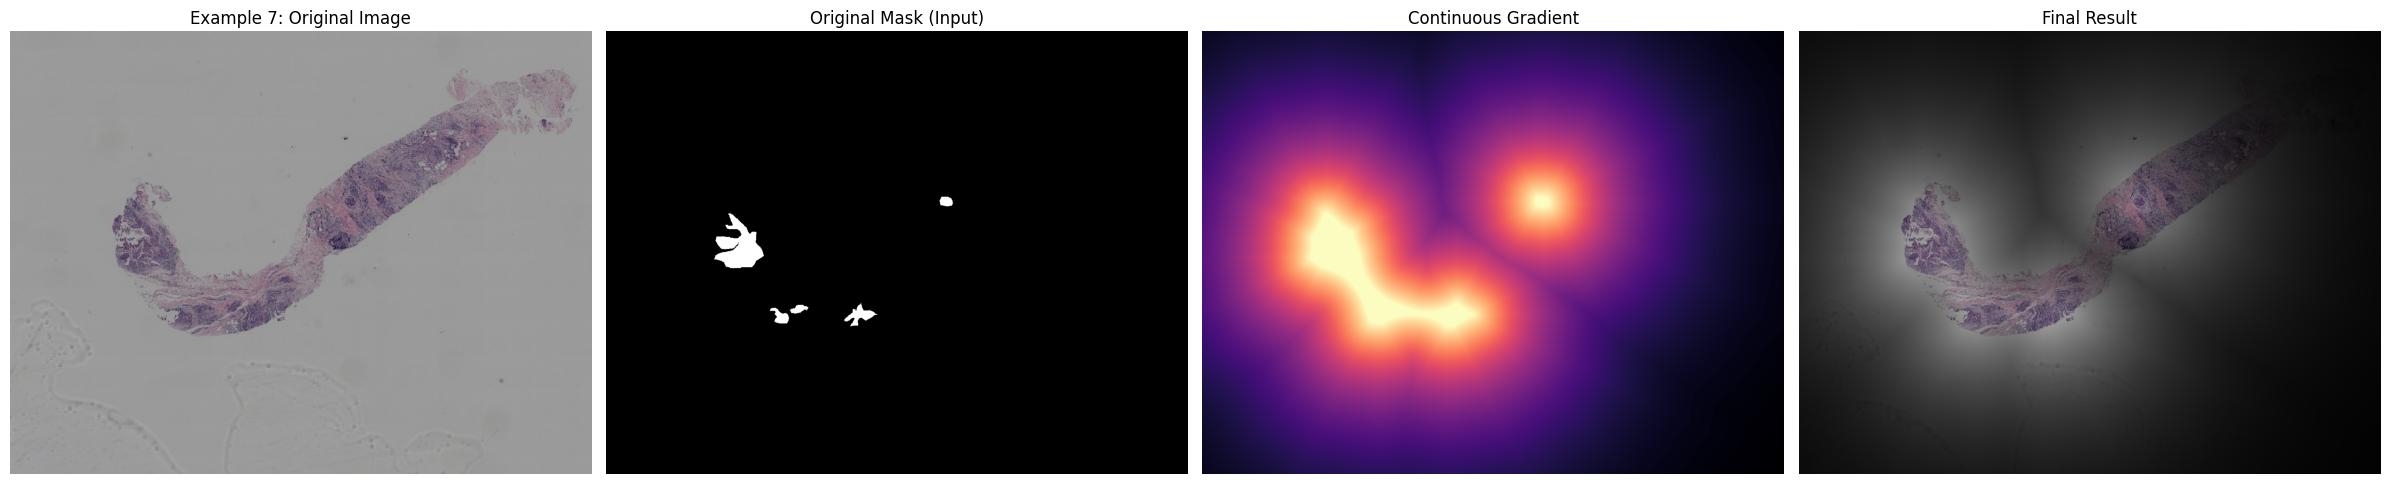

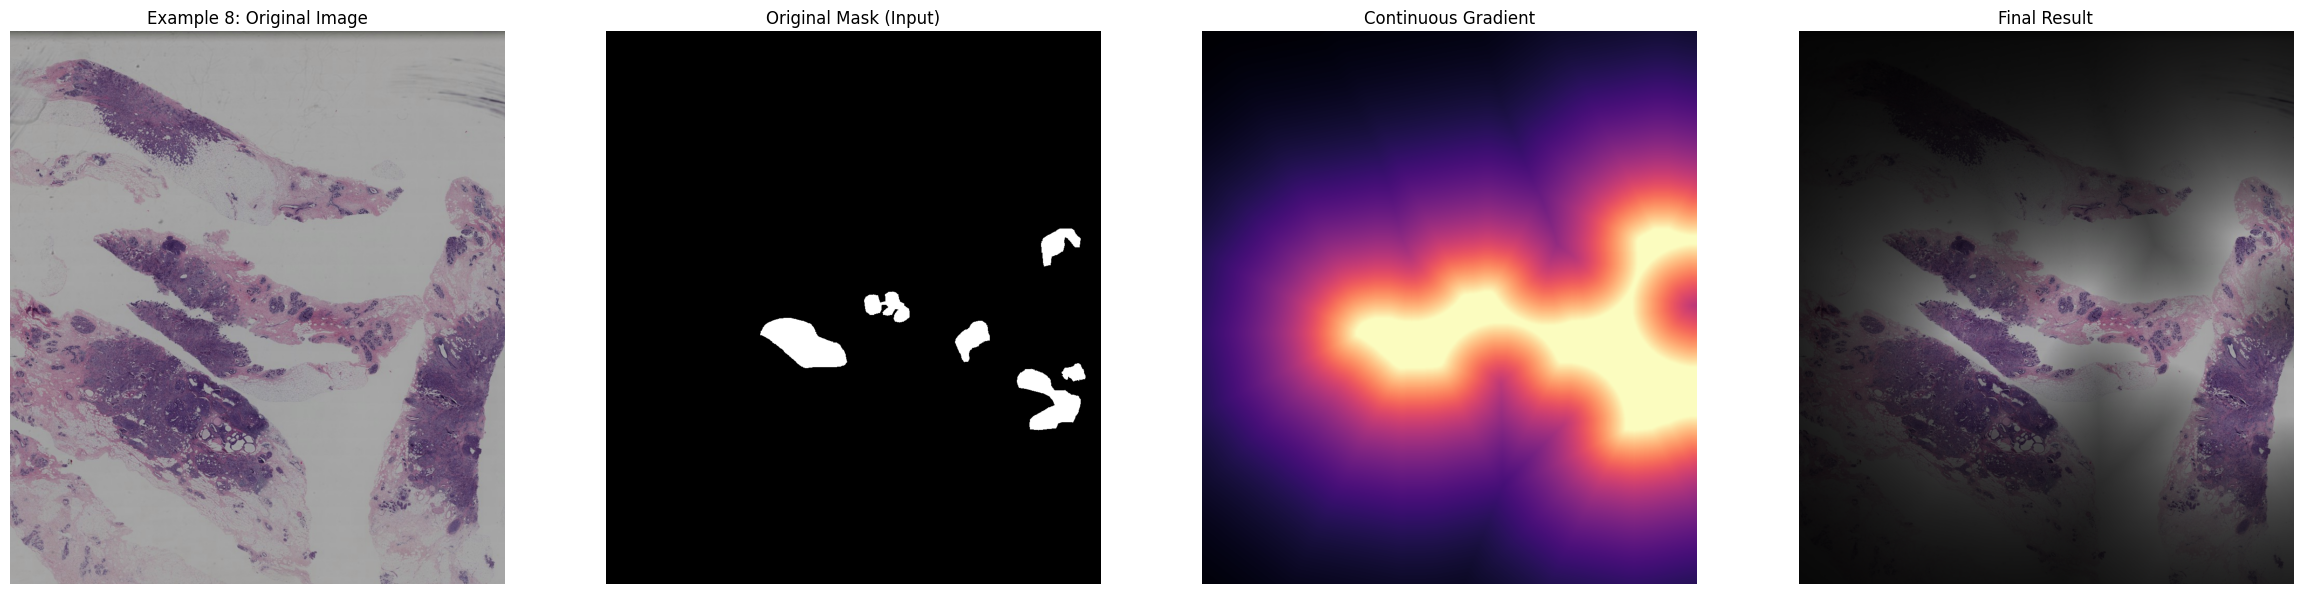

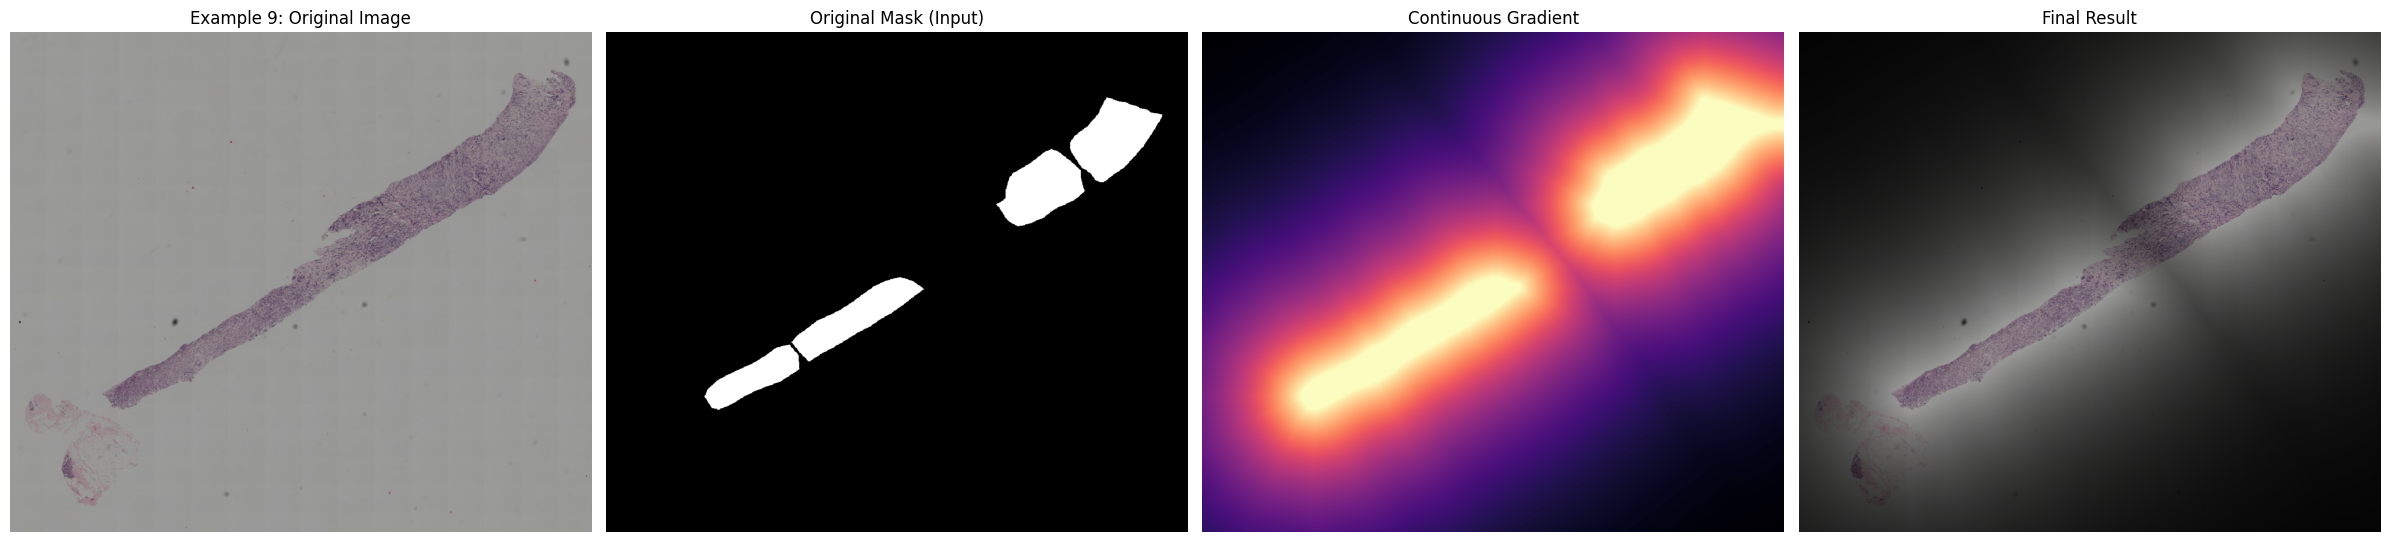

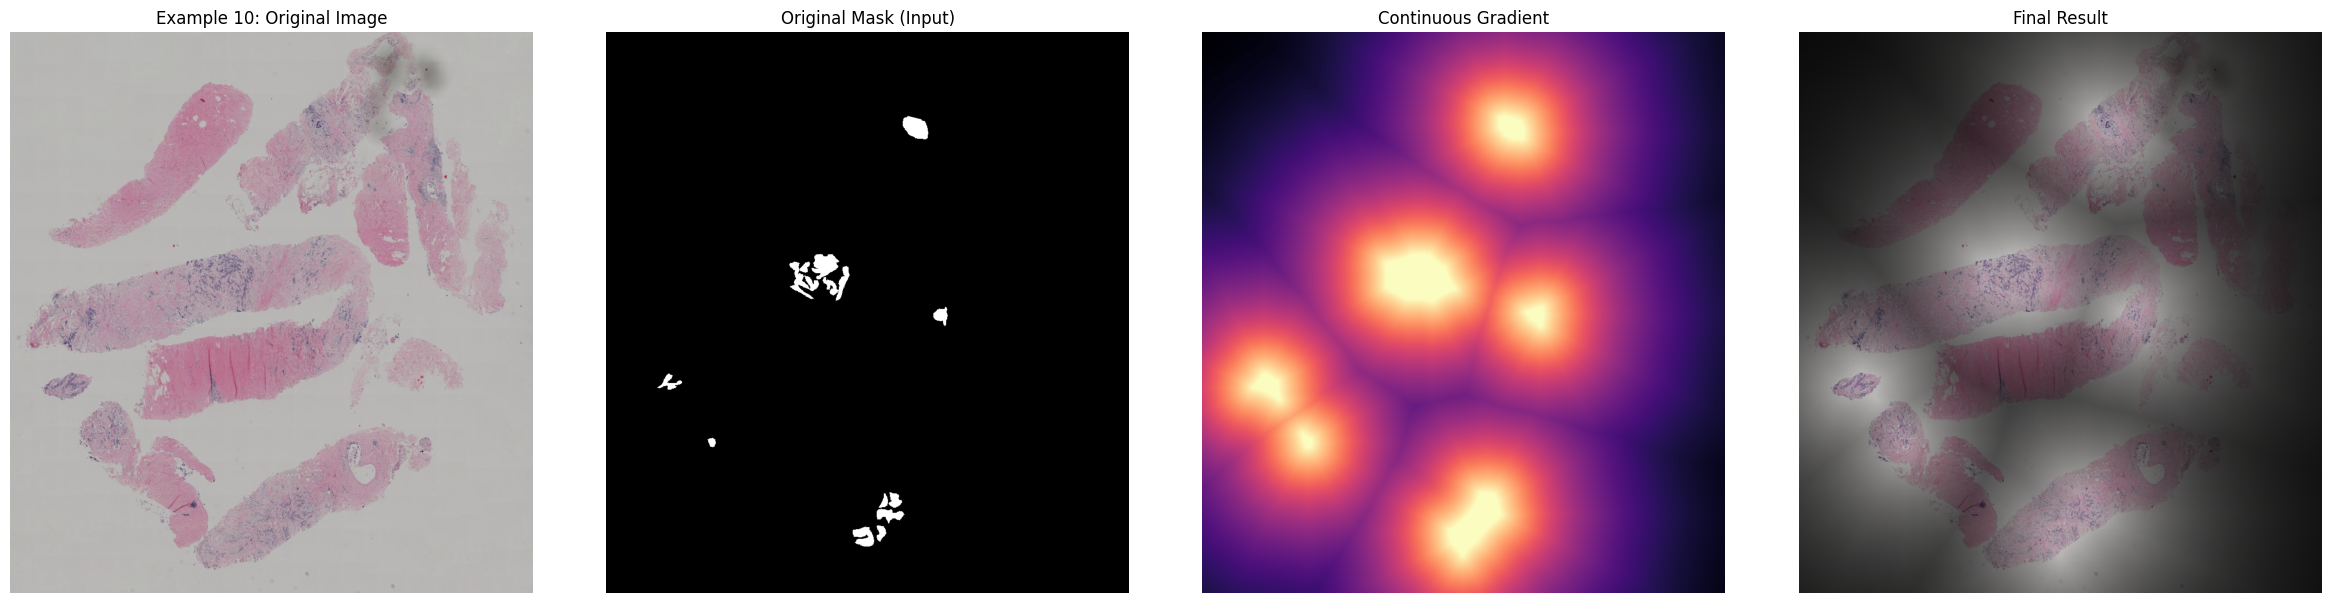

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
folder_path = 'ginger/no_shrek_no_macchie'

# PARAMETERS
# Increase gap size if parts are still disconnected
BRIDGE_GAP_SIZE = 250
FADE_RADIUS = 200
USE_EXPONENTIAL = True

# --- 2. FUNCTION DEFINITION ---
def apply_gradient_focus(img, mask, fade_radius=50, min_visibility=0.0, exp=False, bridge_gap_size=0):
    # Ensure mask is binary
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # --- BRIDGE GAPS ---
    if bridge_gap_size > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (bridge_gap_size, bridge_gap_size))
        # Morphological Close: Dilate then Erode to fill gaps
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Invert Mask for distance transform
    inv_mask = cv2.bitwise_not(binary_mask)

    # Calculate Distance Transform
    dist = cv2.distanceTransform(inv_mask, cv2.DIST_L2, 5)

    # Create Weight Map
    if exp:
        weights = np.exp(-dist/(fade_radius + 1e-5))
    else:
        weights = 1.0 - (dist / (fade_radius + 1e-5))

    # Clip values
    weights = np.maximum(weights, min_visibility)
    weights = np.minimum(weights, 1.0)

    # Apply to Image
    weights_rgb = np.dstack([weights] * 3)

    if weights_rgb.shape[:2] != img.shape[:2]:
        weights_rgb = cv2.resize(weights_rgb, (img.shape[1], img.shape[0]))

    focused_img = (img.astype(np.float32) * weights_rgb).astype(np.uint8)

    return focused_img, weights, binary_mask

# --- 3. PROCESSING LOOP ---
all_files = os.listdir(folder_path)
image_files = [f for f in all_files if f.startswith('img_') and f.endswith('.png')]
image_files.sort()

print(f"Found {len(image_files)} images. Showing first 10 examples...")

count = 0
limit = 10  # Set the number of examples you want to see

for img_filename in image_files:
    if count >= limit:
        break

    # Find corresponding mask
    mask_filename = img_filename.replace("img", "mask")
    img_full_path = os.path.join(folder_path, img_filename)
    mask_full_path = os.path.join(folder_path, mask_filename)

    if not os.path.exists(mask_full_path):
        continue

    # Load Data
    img = cv2.imread(img_full_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_full_path, 0)

    # Process
    result_img, weight_map, bridged_mask = apply_gradient_focus(
        img,
        mask,
        fade_radius=FADE_RADIUS,
        exp=USE_EXPONENTIAL,
        bridge_gap_size=BRIDGE_GAP_SIZE
    )

    # --- VISUALIZATION ---
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))

    # 1. Original Image
    ax[0].imshow(img)
    ax[0].set_title(f"Example {count+1}: Original Image")
    ax[0].axis('off')

    # 2. Original Mask (Raw)
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Original Mask (Input)")
    ax[1].axis('off')

    # 3. Continuous Gradient (Result of bridging + distance transform)
    ax[2].imshow(weight_map, cmap='magma')
    ax[2].set_title("Continuous Gradient")
    ax[2].axis('off')

    # 4. Final Result
    ax[3].imshow(result_img)
    ax[3].set_title("Final Result")
    ax[3].axis('off')

    plt.tight_layout()
    plt.show()

    count += 1

## Duplicate and conflicting images check with hashing(for initial dataset)

### Perceptual hashing

This creates hashes for images in every orientation (rotations of 90 degrees and mirroring) and compares all the hashes in the dataset to find similar images

In [ ]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from PIL import Image
import imagehash
import numpy as np
from tqdm import tqdm

# ================= CONFIGURATION =================
current_folder = os.getcwd()

images_folder = os.path.join(current_folder, 'dataset/clean_data/train_data')
csv_path = os.path.join(current_folder, 'dataset/clean_data/train_labels.csv')

# ================= HELPER FUNCTIONS =================

def get_8_variations_hashes(image, hash_size=8):
    """Generates hashes for the image and all its 7 geometric variations."""
    # Resize to small square to standardize
    img_resized = image.resize((64, 64), Image.Resampling.LANCZOS)
    hashes = set()

    # 1. Normal
    hashes.add(str(imagehash.phash(img_resized, hash_size=hash_size)))

    # 2-4. Rotations (90, 180, 270)
    hashes.add(str(imagehash.phash(img_resized.rotate(90), hash_size=hash_size)))
    hashes.add(str(imagehash.phash(img_resized.rotate(180), hash_size=hash_size)))
    hashes.add(str(imagehash.phash(img_resized.rotate(270), hash_size=hash_size)))

    # 5. Flip (Mirror)
    img_flip = img_resized.transpose(Image.FLIP_LEFT_RIGHT)
    hashes.add(str(imagehash.phash(img_flip, hash_size=hash_size)))

    # 6-8. Flip + Rotations
    hashes.add(str(imagehash.phash(img_flip.rotate(90), hash_size=hash_size)))
    hashes.add(str(imagehash.phash(img_flip.rotate(180), hash_size=hash_size)))
    hashes.add(str(imagehash.phash(img_flip.rotate(270), hash_size=hash_size)))

    return hashes

# ================= MAIN LOGIC =================

def analyze_dataset():
    print(f"📂 Current Work Directory: {current_folder}")
    print(f"🔎 Looking for CSV at: {csv_path}")

    if not os.path.exists(csv_path):
        print("❌ Error: 'train_labels.csv' not found in this folder.")
        print("Please check that you ran the %cd command correctly.")
        return

    if not os.path.exists(images_folder):
        print("❌ Error: 'train_data' folder not found in this folder.")
        return

    df = pd.read_csv(csv_path)
    print(f"✅ Loaded {len(df)} labels.")
    print("🚀 Starting analysis...")

    # Dictionary: Hash -> List of (filename, label)
    hash_registry = {}

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        # --- Handle Filename ---
        if 'image' in df.columns: fname = row['image']
        elif 'filename' in df.columns: fname = row['filename']
        else: fname = str(row.iloc[0]) # Fallback to first column

        # Ensure extension exists
        if not str(fname).lower().endswith('.png'):
            fname = f"{fname}.png"

        # --- Handle Label ---
        label = str(row.iloc[1]) # Fallback to second column

        full_img_path = os.path.join(images_folder, fname)

        if os.path.exists(full_img_path):
            try:
                with Image.open(full_img_path) as img:
                    current_hashes = get_8_variations_hashes(img)

                    for h in current_hashes:
                        if h not in hash_registry:
                            hash_registry[h] = []

                        # Prevent adding exact same file to bucket
                        existing_files = [x[0] for x in hash_registry[h]]
                        if fname not in existing_files:
                            hash_registry[h].append((fname, label))
            except Exception as e:
                print(f"Error reading {fname}: {e}")

    # ================= ANALYZE RESULTS =================

    print("\nAnalyzing for collisions...")

    conflicting_pairs = set() # Different Labels
    duplicate_pairs = set()   # Same Labels

    for h, entries in hash_registry.items():
        if len(entries) > 1:
            for i in range(len(entries)):
                for j in range(i + 1, len(entries)):
                    img_a, label_a = entries[i]
                    img_b, label_b = entries[j]

                    # Sort tuple so (A,B) is same as (B,A)
                    pair_tuple = tuple(sorted([(img_a, label_a), (img_b, label_b)], key=lambda x: x[0]))

                    if label_a != label_b:
                        conflicting_pairs.add(pair_tuple)
                    else:
                        duplicate_pairs.add(pair_tuple)

    # ================= REPORTING =================
    print("\n" + "="*30)
    print("       FINAL REPORT       ")
    print("="*30)

    # 1. CONFLICTS (Different Labels)
    if len(conflicting_pairs) > 0:
        print(f"\n⚠️  CRITICAL: Found {len(conflicting_pairs)} pairs with DIFFERENT labels:")
        conflict_list = []
        for p in conflicting_pairs:
            print(f"   {p[0][0]} ({p[0][1]}) <==> {p[1][0]} ({p[1][1]})")
            conflict_list.append({'Image_A': p[0][0], 'Label_A': p[0][1], 'Image_B': p[1][0], 'Label_B': p[1][1]})

        pd.DataFrame(conflict_list).to_csv('ginger/conflicting_images.csv', index=False)
        print(">> Saved list to 'ginger/conflicting_images.csv'")
    else:
        print("\n✅ No conflicting labels found.")

    # 2. DUPLICATES (Same Labels)
    if len(duplicate_pairs) > 0:
        print(f"\nℹ️  INFO: Found {len(duplicate_pairs)} pairs with SAME labels (Duplicates):")

        duplicate_list = []
        count = 0
        for p in duplicate_pairs:
            if count < 5:
                print(f"   {p[0][0]} == {p[1][0]}")
            duplicate_list.append({'Image_A': p[0][0], 'Image_B': p[1][0], 'Label': p[0][1]})
            count += 1

        if count > 5:
            print(f"   ... and {count - 5} more.")

        pd.DataFrame(duplicate_list).to_csv('ginger/duplicate_images.csv', index=False)
        print(">> Saved list to 'ginger/duplicate_images.csv'")
    else:
        print("\n✅ No duplicates found.")

# Run the function
analyze_dataset()

📂 Current Work Directory: /gdrive/.shortcut-targets-by-id/1u1TRupsAwXrbLPHfTcn7ROJ-D_KQsIwK/ANN-2ndChallenge
🔎 Looking for CSV at: /gdrive/.shortcut-targets-by-id/1u1TRupsAwXrbLPHfTcn7ROJ-D_KQsIwK/ANN-2ndChallenge/dataset/clean_data/train_labels.csv
✅ Loaded 557 labels.
🚀 Starting analysis...


100%|██████████| 557/557 [06:00<00:00,  1.55it/s]


Analyzing for collisions...

       FINAL REPORT       

✅ No conflicting labels found.

✅ No duplicates found.


### Robust hashing

This first puts the images in grayscale and does histogram equalization, then creates hashes for images in every orientation (rotations of 90 degrees and mirroring) and compares all the hashes in the dataset to find similar images

In [ ]:
import os
import pandas as pd
from PIL import Image, ImageOps
import imagehash
import numpy as np
from tqdm import tqdm

# ================= CONFIGURATION =================
current_folder = os.getcwd()
images_folder = os.path.join(current_folder, 'ginger/no_shrek_no_macchie')
csv_path = os.path.join(current_folder, 'ginger/train_labels_cleaned.csv')

# ================= HELPER FUNCTIONS =================

def get_variations_for_image(img_input, hash_size=8):
    """
    Helper to get hashes for 8 geometric variations of a specific PIL image object.
    """
    # Resize to small square
    img_resized = img_input.resize((64, 64), Image.Resampling.LANCZOS)

    hashes = set()

    # Generate the 8 geometric variations
    # 1. Normal
    hashes.add(str(imagehash.phash(img_resized, hash_size=hash_size)))
    # 2. Rot 90
    hashes.add(str(imagehash.phash(img_resized.rotate(90), hash_size=hash_size)))
    # 3. Rot 180
    hashes.add(str(imagehash.phash(img_resized.rotate(180), hash_size=hash_size)))
    # 4. Rot 270
    hashes.add(str(imagehash.phash(img_resized.rotate(270), hash_size=hash_size)))

    # Flip
    img_flip = img_resized.transpose(Image.FLIP_LEFT_RIGHT)

    # 5. Flip Normal
    hashes.add(str(imagehash.phash(img_flip, hash_size=hash_size)))
    # 6. Flip + Rot 90
    hashes.add(str(imagehash.phash(img_flip.rotate(90), hash_size=hash_size)))
    # 7. Flip + Rot 180
    hashes.add(str(imagehash.phash(img_flip.rotate(180), hash_size=hash_size)))
    # 8. Flip + Rot 270
    hashes.add(str(imagehash.phash(img_flip.rotate(270), hash_size=hash_size)))

    return hashes

def get_robust_hashes(image, hash_size=8):
    """
    Generates hashes using TWO methods combined:
    1. Standard Grayscale (Good for exact matches)
    2. Histogram Equalized (Good for different contrast/brightness)
    """
    combined_hashes = set()

    # --- METHOD A: Standard Grayscale (Conservative) ---
    # This catches the "Easy" exact duplicates without noise interference
    img_gray = image.convert("L")
    hashes_a = get_variations_for_image(img_gray, hash_size)
    combined_hashes.update(hashes_a)

    # --- METHOD B: Histogram Equalized (Aggressive) ---
    # This catches "Same structure, different contrast"
    # We equalize the grayscale image to stretch contrast
    img_eq = ImageOps.equalize(img_gray)
    hashes_b = get_variations_for_image(img_eq, hash_size)
    combined_hashes.update(hashes_b)

    return combined_hashes

# ================= MAIN LOGIC =================

def analyze_dataset():
    print(f"📂 Current Work Directory: {current_folder}")

    if not os.path.exists(csv_path):
        print("❌ Error: 'train_labels.csv' not found.")
        return

    df = pd.read_csv(csv_path)
    print(f"✅ Loaded {len(df)} labels.")
    print("🚀 Starting analysis (Using Double-Pass Strategy)...")

    # Dictionary: Hash -> List of (filename, label)
    hash_registry = {}

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        # --- Handle Filename ---
        if 'image' in df.columns: fname = row['image']
        elif 'filename' in df.columns: fname = row['filename']
        else: fname = str(row.iloc[0])

        if not str(fname).lower().endswith('.png'):
            fname = f"{fname}.png"

        label = str(row.iloc[1])
        full_img_path = os.path.join(images_folder, fname)

        if os.path.exists(full_img_path):
            try:
                with Image.open(full_img_path) as img:
                    # KEY CHANGE: We call the robust function here
                    current_hashes = get_robust_hashes(img)

                    for h in current_hashes:
                        if h not in hash_registry:
                            hash_registry[h] = []

                        existing_files = [x[0] for x in hash_registry[h]]
                        if fname not in existing_files:
                            hash_registry[h].append((fname, label))
            except Exception as e:
                print(f"Error reading {fname}: {e}")

    # ================= ANALYZE RESULTS =================

    print("\nAnalyzing for collisions...")

    conflicting_pairs = set() # Different Labels
    duplicate_pairs = set()   # Same Labels

    for h, entries in hash_registry.items():
        if len(entries) > 1:
            for i in range(len(entries)):
                for j in range(i + 1, len(entries)):
                    img_a, label_a = entries[i]
                    img_b, label_b = entries[j]

                    # Sort tuple so (A,B) is same as (B,A)
                    pair_tuple = tuple(sorted([(img_a, label_a), (img_b, label_b)], key=lambda x: x[0]))

                    if label_a != label_b:
                        conflicting_pairs.add(pair_tuple)
                    else:
                        duplicate_pairs.add(pair_tuple)

    # ================= REPORTING =================
    print("\n" + "="*30)
    print("       FINAL REPORT       ")
    print("="*30)

    # 1. CONFLICTS
    if len(conflicting_pairs) > 0:
        print(f"\n⚠️  CRITICAL: Found {len(conflicting_pairs)} pairs with DIFFERENT labels:")
        conflict_list = []
        for p in conflicting_pairs:
            # Short print for console
            # print(f"   {p[0][0]} <==> {p[1][0]}")
            conflict_list.append({'Image_A': p[0][0], 'Label_A': p[0][1], 'Image_B': p[1][0], 'Label_B': p[1][1]})

        # Save detailed CSV
        pd.DataFrame(conflict_list).to_csv('ginger/conflicting_images_color.csv', index=False)
        print(">> Saved detailed list to 'ginger/conflicting_images_color.csv'")

        # Print a few examples
        for i, p in enumerate(conflicting_pairs):
            if i < 10:
                print(f"   {p[0][0]} ({p[0][1]}) <==> {p[1][0]} ({p[1][1]})")
            else:
                print(f"   ... and {len(conflicting_pairs)-10} more")
                break
    else:
        print("\n✅ No conflicting labels found.")

    # 2. DUPLICATES
    if len(duplicate_pairs) > 0:
        print(f"\nℹ️  INFO: Found {len(duplicate_pairs)} pairs with SAME labels (Duplicates):")
        duplicate_list = []
        for p in duplicate_pairs:
            duplicate_list.append({'Image_A': p[0][0], 'Image_B': p[1][0], 'Label': p[0][1]})

        pd.DataFrame(duplicate_list).to_csv('ginger/duplicate_images_color.csv', index=False)
        print(">> Saved list to 'ginger/duplicate_images_color.csv'")
    else:
        print("\n✅ No duplicates found.")

# Run the function
analyze_dataset()

📂 Current Work Directory: /gdrive/.shortcut-targets-by-id/1u1TRupsAwXrbLPHfTcn7ROJ-D_KQsIwK/ANN-2ndChallenge
✅ Loaded 1168 labels.
🚀 Starting analysis (Using Double-Pass Strategy)...


100%|██████████| 1168/1168 [01:47<00:00, 10.85it/s]


Analyzing for collisions...

       FINAL REPORT       

⚠️  CRITICAL: Found 81 pairs with DIFFERENT labels:
>> Saved detailed list to 'ginger/conflicting_images_color.csv'
   img_0170.png (Luminal A) <==> img_0393.png (Luminal B)
   img_0709.png (Luminal B) <==> img_1135.png (HER2(+))
   img_0221.png (Luminal B) <==> img_0561.png (HER2(+))
   img_0376.png (Triple negative) <==> img_0485.png (Luminal A)
   img_0501.png (Luminal B) <==> img_0925.png (HER2(+))
   img_0573.png (HER2(+)) <==> img_0636.png (Triple negative)
   img_0081.png (Luminal A) <==> img_0360.png (Luminal B)
   img_0873.png (HER2(+)) <==> img_0961.png (Luminal B)
   img_0585.png (Luminal A) <==> img_0983.png (HER2(+))
   img_1195.png (Luminal A) <==> img_1264.png (Luminal B)
   ... and 71 more

ℹ️  INFO: Found 30 pairs with SAME labels (Duplicates):
>> Saved list to 'ginger/duplicate_images_color.csv'


## Resizing and padding operations

### Rescaling to 224 with area interpolation and replicating borders for padding

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# --- CONFIGURATION ---
input_folder = 'ginger/no_shrek_no_macchie'

# Update this path to where you want the single folder to be
output_folder = 'dataset/224_cleaned_area_replicate'

# Create the single output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
TARGET_SIZE = 224

def resize_and_pad(image, target_size, is_mask=False):
    h, w = image.shape[:2]

    # 1. Calculate Scaling Factor
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)

    # 2. Resize
    # Use INTER_AREA for shrinking (best quality)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    if is_mask:
        # Re-binarize mask after resizing to avoid gray edges
        _, resized = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)

    # 3. Calculate Padding Amounts
    delta_w = target_size - new_w
    delta_h = target_size - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # 4. Apply Padding
    if is_mask:
        # --- MASK: ALWAYS CONSTANT BLACK ---
        padded_image = cv2.copyMakeBorder(
            resized,
            top, bottom, left, right,
            cv2.BORDER_CONSTANT,
            value=[0, 0, 0] # Black
        )
    else:
        # --- IMAGE: REPLICATE BORDER ---
        padded_image = cv2.copyMakeBorder(
            resized,
            top, bottom, left, right,
            cv2.BORDER_REPLICATE
        )

    return padded_image

# --- MAIN LOOP ---
all_files = os.listdir(input_folder)
img_files = [f for f in all_files if f.startswith('img_') and f.endswith('.png')]

print(f"Processing {len(img_files)} images...")

for img_filename in tqdm(img_files):
    mask_filename = img_filename.replace("img", "mask")

    img_path = os.path.join(input_folder, img_filename)
    mask_path = os.path.join(input_folder, mask_filename)

    if not os.path.exists(mask_path): continue

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)

    # Apply Resize & Pad
    processed_img = resize_and_pad(img, TARGET_SIZE, is_mask=False)
    processed_mask = resize_and_pad(mask, TARGET_SIZE, is_mask=True)

    # --- SAVE TO THE SAME FOLDER ---
    # Both images and masks go to 'output_folder'
    cv2.imwrite(os.path.join(output_folder, img_filename), processed_img)
    cv2.imwrite(os.path.join(output_folder, mask_filename), processed_mask)

print("Done.")
print(f"All files saved to: {output_folder}")

Processing 958 images...


100%|██████████| 958/958 [02:47<00:00,  5.72it/s]

Done.
All files saved to: dataset/224_cleaned_area_replicate


### Rescaling to 224 with area interpolation and black padding (border.constant)

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# --- CONFIGURATION ---
input_folder = 'ginger/no_shrek_no_macchie'

output_folder = 'dataset/224_padded_black'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
TARGET_SIZE = 224

def resize_and_pad(image, target_size, is_mask=False):
    h, w = image.shape[:2]

    # 1. Calculate Scaling Factor
    scale = target_size / max(h, w)
    new_w = max(1, int(w * scale))
    new_h = max(1, int(h * scale))

    # 2. Resize
    # Use INTER_AREA for shrinking (best quality)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    if is_mask:
        # Re-binarize mask after resizing to avoid gray edges
        _, resized = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)

    # 3. Calculate Padding Amounts
    delta_w = target_size - new_w
    delta_h = target_size - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # 4. Apply Padding
    if is_mask:
        # --- MASK: ALWAYS CONSTANT BLACK ---
        padded_image = cv2.copyMakeBorder(
            resized,
            top, bottom, left, right,
            cv2.BORDER_CONSTANT,
            value=[0, 0, 0] # Black
        )
    else:
        # --- IMAGE: CONSTANT WHITE ---
        padded_image = cv2.copyMakeBorder(
            resized,
            top, bottom, left, right,
            cv2.BORDER_CONSTANT,
            value=[0, 0, 0] # [B, G, R] all 0
        )

    return padded_image

# --- MAIN LOOP ---
all_files = os.listdir(input_folder)
img_files = [f for f in all_files if f.startswith('img_') and f.endswith('.png')]

print(f"Processing {len(img_files)} images...")

for img_filename in tqdm(img_files):
    mask_filename = img_filename.replace("img", "mask")

    img_path = os.path.join(input_folder, img_filename)
    mask_path = os.path.join(input_folder, mask_filename)

    if not os.path.exists(mask_path): continue

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)

    # Apply Resize & Pad
    processed_img = resize_and_pad(img, TARGET_SIZE, is_mask=False)
    processed_mask = resize_and_pad(mask, TARGET_SIZE, is_mask=True)

    # --- SAVE TO THE SAME FOLDER ---
    cv2.imwrite(os.path.join(output_folder, img_filename), processed_img)
    cv2.imwrite(os.path.join(output_folder, mask_filename), processed_mask)

print("Done.")
print(f"All files saved to: {output_folder}")

Processing 958 images...


100%|██████████| 958/958 [02:03<00:00,  7.75it/s]

Done.
All files saved to: dataset/224_padded_black


### Visualize resizing effect

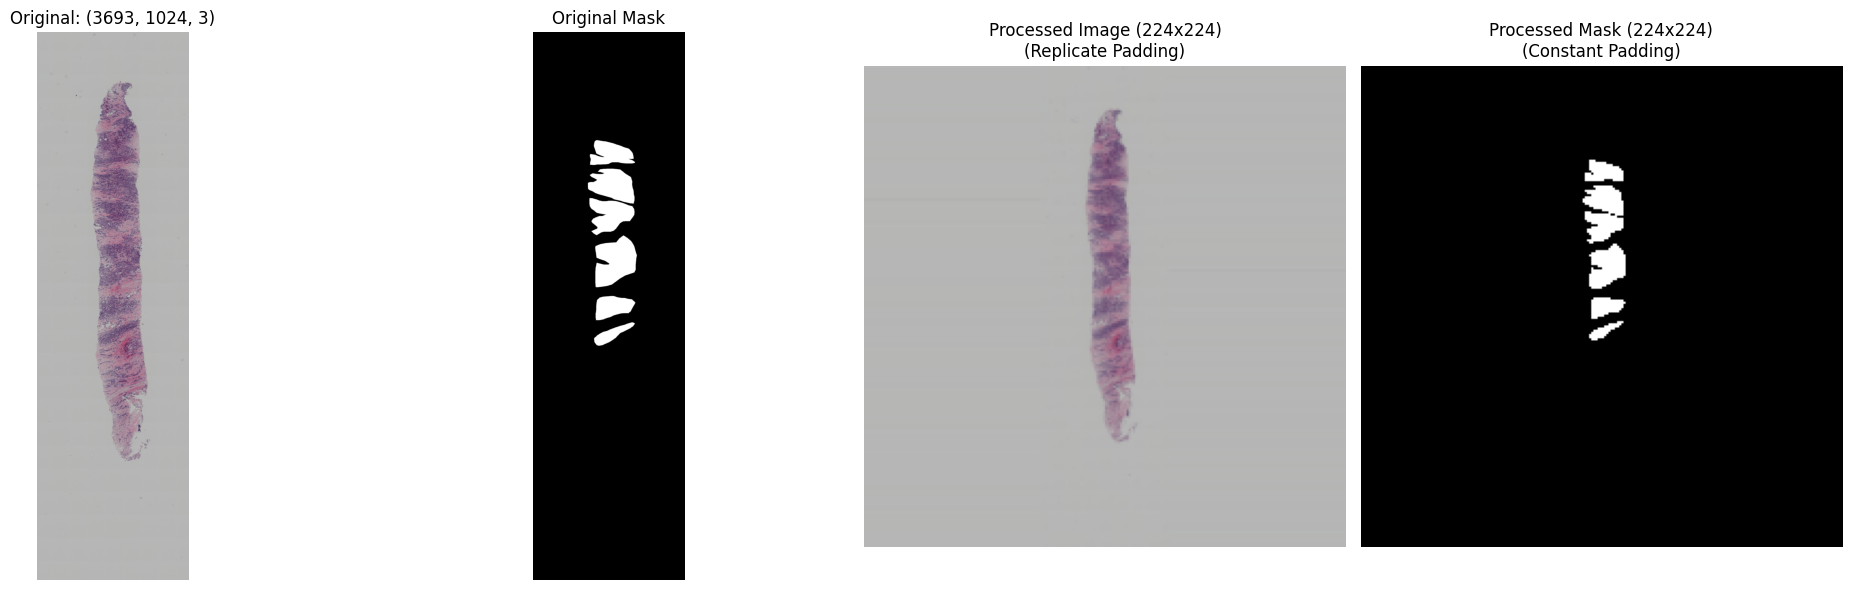

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# --- CONFIGURATION ---
folder_path = 'ginger/no_shrek_no_macchie'
TARGET_SIZE = 224

# --- THE FUNCTION (Interpolation: Area, Padding: Replicate) ---
def resize_and_pad_replicate(image, target_size, is_mask=False):
    h, w = image.shape[:2]

    # 1. Resize (Shrinking)
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)

    # Use INTER_AREA for high quality shrinking
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    if is_mask:
        # Keep mask binary
        _, resized = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)

    # 2. Calculate Padding
    delta_w = target_size - new_w
    delta_h = target_size - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # 3. Apply Padding
    if is_mask:
        # Mask is ALWAYS black padding (background)
        padded = cv2.copyMakeBorder(
            resized, top, bottom, left, right,
            cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )
    else:
        # Image uses REPLICATE to smear the edge pixels
        padded = cv2.copyMakeBorder(
            resized, top, bottom, left, right,
            cv2.BORDER_REPLICATE
        )

    return padded

# --- VISUALIZATION SCRIPT ---
# Get list of images
all_files = os.listdir(folder_path)
img_files = [f for f in all_files if f.startswith('img_') and f.endswith('.png')]

# Pick a random image to test (or select index 0 for the first one)
# using random so you can run the cell multiple times to see different examples
test_filename = "img_0012.png"#random.choice(img_files)
mask_filename = test_filename.replace("img", "mask")

img_path = os.path.join(folder_path, test_filename)
mask_path = os.path.join(folder_path, mask_filename)

if os.path.exists(mask_path):
    # Load
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB for plotting
    mask = cv2.imread(mask_path, 0)

    # Process
    processed_img = resize_and_pad_replicate(img, TARGET_SIZE, is_mask=False)
    processed_mask = resize_and_pad_replicate(mask, TARGET_SIZE, is_mask=True)

    # Plot
    fig, ax = plt.subplots(1, 4, figsize=(20, 6))

    # 1. Original Image
    ax[0].imshow(img)
    ax[0].set_title(f"Original: {img.shape}")
    ax[0].axis('off')

    # 2. Original Mask
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Original Mask")
    ax[1].axis('off')

    # 3. Result Image (Look at the edges!)
    ax[2].imshow(processed_img)
    ax[2].set_title(f"Processed Image ({TARGET_SIZE}x{TARGET_SIZE})\n(Replicate Padding)")
    ax[2].axis('off')

    # 4. Result Mask (Should be black padded)
    ax[3].imshow(processed_mask, cmap='gray')
    ax[3].set_title(f"Processed Mask ({TARGET_SIZE}x{TARGET_SIZE})\n(Constant Padding)")
    ax[3].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"Mask not found for {test_filename}")

### 224 Cropping to the center (no padding)

Taking a single 224x224 crop of the center of the image

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# --- CONFIGURATION ---
input_folder = 'ginger/no_shrek_no_macchie'
output_folder = 'dataset/224_center_cropped_fixed'
TARGET_SIZE = 224

os.makedirs(output_folder, exist_ok=True)

def resize_and_center_crop(image, target_size, is_mask=False):
    h, w = image.shape[:2]

    # 1. Determine Scaling Factor based on the SMALLER dimension
    # This guarantees the image covers the whole 224x224 box
    scale = target_size / min(h, w)

    # 2. Calculate New Dimensions (THE FIX)
    # We round UP (ceil) or simply force it to be at least target_size.
    # forcing max(..., target_size) prevents the 223px rounding error.
    new_w = max(target_size, int(round(w * scale)))
    new_h = max(target_size, int(round(h * scale)))

    # 3. Resize
    # Using INTER_AREA is good, but if we are enlarging tiny images, INTER_LINEAR is safer.
    # However, since we expect big images, we stick to AREA unless the scale is > 1.
    interp = cv2.INTER_LINEAR if scale > 1 else cv2.INTER_AREA
    resized = cv2.resize(image, (new_w, new_h), interpolation=interp)

    if is_mask:
        _, resized = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)

    # 4. Center Crop
    # Now valid because new_w and new_h are guaranteed >= target_size
    start_x = (new_w - target_size) // 2
    start_y = (new_h - target_size) // 2

    cropped = resized[start_y : start_y + target_size,
                      start_x : start_x + target_size]

    return cropped

# --- MAIN LOOP ---
all_files = os.listdir(input_folder)
img_files = [f for f in all_files if f.startswith('img_') and f.endswith('.png')]

print(f"Processing {len(img_files)} images...")

for img_filename in tqdm(img_files):
    mask_filename = img_filename.replace("img", "mask")

    img_path = os.path.join(input_folder, img_filename)
    mask_path = os.path.join(input_folder, mask_filename)

    if not os.path.exists(mask_path): continue

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)

    # --- DEBUG: Catch the problem file ---
    if "img_0814" in img_filename:
        print(f"\nDEBUG: Found img_0814. Original size: {img.shape}")

    # Apply Function
    processed_img = resize_and_center_crop(img, TARGET_SIZE, is_mask=False)
    processed_mask = resize_and_center_crop(mask, TARGET_SIZE, is_mask=True)

    # --- SAFETY CHECK ---
    # If for some reason the output is still wrong, don't save a broken file
    if processed_img.shape[0] != TARGET_SIZE or processed_img.shape[1] != TARGET_SIZE:
        print(f"Error processing {img_filename}: Output shape is {processed_img.shape}")
        continue

    # Save
    cv2.imwrite(os.path.join(output_folder, img_filename), processed_img)
    cv2.imwrite(os.path.join(output_folder, mask_filename), processed_mask)

print("Done.")
print(f"All files saved to: {output_folder}")

Processing 958 images...


  6%|▌         | 55/958 [00:22<01:03, 14.18it/s]


DEBUG: Found img_0814. Original size: (1024, 690, 3)


100%|██████████| 958/958 [02:01<00:00,  7.90it/s]

Done.
All files saved to: dataset/224_center_cropped_fixed


## Color standardization and contrast enhancement

### Masked reinhard standardization

background cleaning + contrast enhancement + color standardization

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# --- CONFIGURATION ---
input_folder = 'dataset/clean_data/train_data'
output_folder = 'dataset/reinhard_standardization'

# USE THE SAME REFERENCE IMAGE AS BEFORE
REFERENCE_IMAGE_PATH = 'dataset/original_data/train_data/img_0040.png'

os.makedirs(output_folder, exist_ok=True)

def get_tissue_mask(img_rgb):
    """
    Creates a binary mask (0 or 255).
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    # Otsu thresholding to separate tissue from background
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return mask

def get_masked_mean_and_std(img_lab, mask):
    """
    Calculates Mean and Std ONLY for pixels where mask is True.
    """
    # mask > 0 converts the 0/255 mask to a boolean mask for indexing
    tissue_pixels = img_lab[mask > 0]

    if tissue_pixels.size == 0:
        return np.zeros(3), np.zeros(3)

    mean = np.mean(tissue_pixels, axis=0)
    std = np.std(tissue_pixels, axis=0)
    return mean, std

def blend_with_white_background(original_normalized, tissue_mask):
    """
    Takes the normalized image and blends it into a pure white background
    using the tissue mask.
    """
    # 1. Prepare the Mask for Blending
    # We dilate (expand) the mask slightly to ensure we include the faint edges of cells
    kernel = np.ones((3,3), np.uint8)
    expanded_mask = cv2.dilate(tissue_mask, kernel, iterations=1)

    # Blur the mask to create a soft transition (Alpha channel)
    # This prevents jagged pixelated edges between tissue and white background
    soft_mask = cv2.GaussianBlur(expanded_mask, (5, 5), 0)

    # Normalize mask to range 0.0 to 1.0 for math
    alpha = soft_mask.astype(float) / 255.0

    # Make alpha 3-channel to match RGB image
    alpha = cv2.merge([alpha, alpha, alpha])

    # 2. Create Pure White Background
    white_background = np.full_like(original_normalized, 255)

    # 3. Alpha Blend:
    # Final = (Tissue * Alpha) + (White * (1 - Alpha))
    foreground = original_normalized.astype(float)
    background = white_background.astype(float)

    blended = (foreground * alpha) + (background * (1.0 - alpha))

    return blended.astype(np.uint8)

def masked_reinhard_normalization(target_img, ref_stats):
    # 1. Identify Tissue
    mask = get_tissue_mask(target_img)

    if np.sum(mask) == 0:
        return target_img

    # 2. Convert to LAB and Get Stats
    target_lab = cv2.cvtColor(target_img, cv2.COLOR_BGR2LAB)
    target_mean, target_std = get_masked_mean_and_std(target_lab, mask)

    # 3. Apply Normalization Math
    target_lab = target_lab.astype("float32")
    l, a, b = cv2.split(target_lab)

    l -= target_mean[0]
    l = l * (ref_stats['std'][0] / (target_std[0] + 1e-5))
    l += ref_stats['mean'][0]

    a -= target_mean[1]
    a = a * (ref_stats['std'][1] / (target_std[1] + 1e-5))
    a += ref_stats['mean'][1]

    b -= target_mean[2]
    b = b * (ref_stats['std'][2] / (target_std[2] + 1e-5))
    b += ref_stats['mean'][2]

    l = np.clip(l, 0, 255)
    a = np.clip(a, 0, 255)
    b = np.clip(b, 0, 255)

    transfer_lab = cv2.merge([l, a, b]).astype("uint8")
    transfer_rgb = cv2.cvtColor(transfer_lab, cv2.COLOR_LAB2BGR)

    # --- NEW STEP: FORCE BACKGROUND TO WHITE ---
    final_result = blend_with_white_background(transfer_rgb, mask)

    return final_result

# --- PREPARE REFERENCE STATS ---
print(f"Loading reference: {REFERENCE_IMAGE_PATH}")
ref_img = cv2.imread(REFERENCE_IMAGE_PATH)
ref_mask = get_tissue_mask(ref_img)
ref_lab = cv2.cvtColor(ref_img, cv2.COLOR_BGR2LAB)
ref_mean, ref_std = get_masked_mean_and_std(ref_lab, ref_mask)

ref_stats = {'mean': ref_mean, 'std': ref_std}

# --- MAIN LOOP ---
all_files = os.listdir(input_folder)
img_files = [f for f in all_files if f.startswith('img_') and f.endswith('.png')]

print(f"Normalizing {len(img_files)} images...")

for img_filename in tqdm(img_files):
    mask_filename = img_filename.replace("img", "mask")
    img_path = os.path.join(input_folder, img_filename)
    mask_path = os.path.join(input_folder, mask_filename)

    img = cv2.imread(img_path)
    if img is None: continue

    # Copy Mask
    if os.path.exists(mask_path):
        mask_file = cv2.imread(mask_path, 0)
        cv2.imwrite(os.path.join(output_folder, mask_filename), mask_file)

    # Apply Normalization + White Background Fix
    try:
        normalized_img = masked_reinhard_normalization(img, ref_stats)
        cv2.imwrite(os.path.join(output_folder, img_filename), normalized_img)
    except Exception as e:
        print(f"Error {img_filename}: {e}")

print("Done. Pink background removed.")

Loading reference: dataset/original_data/train_data/img_0040.png
Normalizing 559 images...


100%|██████████| 559/559 [03:47<00:00,  2.46it/s]

Done. Pink background removed.


### Contrast enhancement

background cleaning + contrast enhancement

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# --- CONFIGURATION ---
# Use the folder with your cropped/resized images
input_folder = 'dataset/smart_tiles/images'
output_folder = 'dataset/contrast_enhancement_v2'

os.makedirs(output_folder, exist_ok=True)
CLIP_LIMIT = 2.0


def get_tissue_mask(image):
    """
    Generates a binary mask of the tissue using Otsu's thresholding.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Otsu finds the optimal split between background and tissue
    # THRESH_BINARY_INV means: Tissue = White (255), Background = Black (0)
    thresh_val, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return mask

def apply_clahe_masked(image, mask, clip_limit=2.0):
    """
    1. Applies CLAHE to the whole image (creating artifacts).
    2. Blends the result with a pure white background using the mask.
    """
    # --- STEP 1: Apply CLAHE (The "Dirty" Enhancement) ---
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)

    merged = cv2.merge((l_enhanced, a, b))
    enhanced_img = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

    # --- STEP 2: Prepare for Blending ---
    # Create a pure white background image
    white_background = np.full_like(image, 255)

    # --- STEP 3: Soften the Mask ---
    # We dilate slightly to make sure we don't cut off cell edges
    kernel = np.ones((3,3), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)

    # Gaussian Blur creates a "soft" edge (alpha channel)
    # This removes the jagged, pixelated look between tissue and white background
    soft_mask = cv2.GaussianBlur(dilated_mask, (5, 5), 0)

    # Convert mask to 0.0 - 1.0 float range for math
    alpha = soft_mask.astype(float) / 255.0
    alpha = cv2.merge([alpha, alpha, alpha]) # Duplicate for 3 channels

    # --- STEP 4: Blend ---
    # Formula: (EnhancedTissue * alpha) + (WhiteBackground * (1 - alpha))
    foreground = enhanced_img.astype(float)
    background = white_background.astype(float)

    final_image = (foreground * alpha) + (background * (1.0 - alpha))

    return final_image.astype(np.uint8)

# --- MAIN LOOP ---
all_files = os.listdir(input_folder)
img_files = [f for f in all_files if f.startswith('img_') and f.endswith('.png')]

print(f"Processing {len(img_files)} images...")

for img_filename in tqdm(img_files):
    mask_filename = img_filename.replace("img", "mask")

    img_path = os.path.join(input_folder, img_filename)
    mask_path = os.path.join(input_folder, mask_filename)

    img = cv2.imread(img_path)
    if img is None: continue

    # 1. Copy the Ground Truth Mask Unaltered
    if os.path.exists(mask_path):
        gt_mask = cv2.imread(mask_path, 0)
        cv2.imwrite(os.path.join(output_folder, mask_filename), gt_mask)

    # 2. Get Tissue Mask (To clean background)
    tissue_mask = get_tissue_mask(img)

    # 3. Apply Enhancement + Background Cleaning
    final_result = apply_clahe_masked(img, tissue_mask, clip_limit=CLIP_LIMIT)

    # 4. Save
    cv2.imwrite(os.path.join(output_folder, img_filename), final_result)

print("Done. Halos and dark backgrounds removed.")

Processing 559 images...


100%|██████████| 559/559 [03:08<00:00,  2.96it/s]

Done. Halos and dark backgrounds removed.


### Background cleaning (setting background to black)

#### With OTSU thresholding

Works on Brightness/Intensity (Grayscale)

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# --- CONFIGURATION ---
input_folder = 'dataset/smart_tiles_test/images'
output_folder = 'dataset/smart_tiles_black_test_otsu'

os.makedirs(output_folder, exist_ok=True)

def get_tissue_mask(image):
    """
    Generates a binary mask of the tissue using Otsu's thresholding.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Otsu finds the split between background (light) and tissue (dark)
    # THRESH_BINARY_INV means: Tissue = White (255), Background = Black (0)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return mask

def clean_background_only(image, mask):
    """
    Blends the ORIGINAL image with a white background using a soft mask.
    Preserves original colors and contrast of the tissue.
    """
    # 1. Create Pure black Background
    white_background = np.full_like(image, 0)

    # 2. Soften the Mask (Create Alpha Channel)
    # Dilate slightly to ensure we include the faint cell membranes
    kernel = np.ones((3,3), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)

    # Gaussian Blur creates the soft edge (alpha transition)
    soft_mask = cv2.GaussianBlur(dilated_mask, (5, 5), 0)

    # Normalize mask to 0.0 - 1.0 range
    alpha = soft_mask.astype(float) / 255.0
    alpha = cv2.merge([alpha, alpha, alpha]) # 3 Channels

    # 3. Blend Original + White
    foreground = image.astype(float)
    background = white_background.astype(float)

    # The Math: Keep Foreground where alpha is 1, use White where alpha is 0
    cleaned_image = (foreground * alpha) + (background * (1.0 - alpha))

    return cleaned_image.astype(np.uint8)

# --- MAIN LOOP ---
all_files = os.listdir(input_folder)
img_files = [f for f in all_files if f.startswith('img_') and f.endswith('.png')]

print(f"Cleaning background for {len(img_files)} images...")

for img_filename in tqdm(img_files):
    mask_filename = img_filename.replace("img", "mask")

    img_path = os.path.join(input_folder, img_filename)
    mask_path = os.path.join(input_folder, mask_filename)

    img = cv2.imread(img_path)
    if img is None: continue

    # 1. Copy the Ground Truth Mask Unaltered
    if os.path.exists(mask_path):
        gt_mask = cv2.imread(mask_path, 0)
        cv2.imwrite(os.path.join(output_folder, mask_filename), gt_mask)

    # 2. Get Tissue Mask (Computed from the image)
    tissue_mask = get_tissue_mask(img)

    # 3. Apply Cleaning (No Contrast Enhancement)
    final_result = clean_background_only(img, tissue_mask)

    # 4. Save
    cv2.imwrite(os.path.join(output_folder, img_filename), final_result)

print("Done. Backgrounds are now pure white, tissue is unaltered.")

Cleaning background for 1532 images...


100%|██████████| 1532/1532 [01:23<00:00, 18.33it/s]

Done. Backgrounds are now pure white, tissue is unaltered.


#### With HSV

Works on Color (Chromaticity)

In [ ]:
import cv2
import numpy as np
import os
import shutil
from tqdm import tqdm

# --- CONFIGURATION ---
# Base path based on your screenshot
base_input_folder = 'dataset/original_data'
input_img_dir = os.path.join(base_input_folder, 'images')
input_mask_dir = os.path.join(base_input_folder, 'masks')

# Output path (will recreate the structure)
base_output_folder = 'dataset/smart_tiles_black_bg'
output_img_dir = os.path.join(base_output_folder, 'images')
output_mask_dir = os.path.join(base_output_folder, 'masks')

# Create directories
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

def get_tissue_mask_hsv(image):
    """
    Generates a binary mask of the tissue using HSV Saturation.
    Safer for pink tissue on grey background.
    """
    # 1. Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 2. Extract Saturation (Color intensity)
    saturation = hsv[:, :, 1]

    # 3. Threshold Saturation (Otsu)
    # Background (gray) ~ 0 saturation, Tissue (pink) > 0 saturation
    _, mask = cv2.threshold(saturation, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 4. Morphological Close (Fill small holes inside tissue)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 5. Morphological Open (Remove noise in background)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    return mask

def clean_background_only(image, mask):
    """
    Blends the ORIGINAL image with a white background using the mask.
    """
    # 1. White Background
    white_background = np.full_like(image, 0)

    # 2. Soften edges (Alpha Blending)
    kernel = np.ones((3,3), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    soft_mask = cv2.GaussianBlur(dilated_mask, (5, 5), 0)

    # Normalize to 0-1
    alpha = soft_mask.astype(float) / 255.0
    alpha = cv2.merge([alpha, alpha, alpha])

    # 3. Blend
    foreground = image.astype(float)
    background = white_background.astype(float)
    cleaned_image = (foreground * alpha) + (background * (1.0 - alpha))

    return cleaned_image.astype(np.uint8)

# --- MAIN LOOP ---
# Get list of images
img_files = [f for f in os.listdir(input_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Processing {len(img_files)} pairs from '{base_input_folder}'...")

for img_filename in tqdm(img_files):

    # --- 1. DETERMINE PATHS ---
    src_img_path = os.path.join(input_img_dir, img_filename)
    dst_img_path = os.path.join(output_img_dir, img_filename)

    # Try to find the matching mask.
    # Logic: Check if it has the exact same name, OR if it uses the 'img' -> 'mask' naming convention
    mask_filename_exact = img_filename
    mask_filename_replaced = img_filename.replace("img", "mask") # Handle img_01.png -> mask_01.png convention

    if os.path.exists(os.path.join(input_mask_dir, mask_filename_replaced)):
        mask_filename = mask_filename_replaced
    elif os.path.exists(os.path.join(input_mask_dir, mask_filename_exact)):
        mask_filename = mask_filename_exact
    else:
        # If no mask found, we still process the image, but we can't copy a mask
        mask_filename = None

    # --- 2. LOAD IMAGE ---
    img = cv2.imread(src_img_path)
    if img is None: continue

    # --- 3. CLEAN BACKGROUND (HSV METHOD) ---
    # Generate the mask based on color saturation
    tissue_mask = get_tissue_mask_hsv(img)

    # Apply the cleaning
    final_result = clean_background_only(img, tissue_mask)

    # Save the cleaned image
    cv2.imwrite(dst_img_path, final_result)

    # --- 4. HANDLE GROUND TRUTH MASK ---
    # We simply copy the ground truth mask to the new folder so your dataset is ready for training
    if mask_filename:
        src_mask_path = os.path.join(input_mask_dir, mask_filename)
        dst_mask_path = os.path.join(output_mask_dir, mask_filename)
        shutil.copy2(src_mask_path, dst_mask_path)

print(f"Done! Cleaned dataset is in: {base_output_folder}")

Processing 1777 pairs from 'dataset/smart_tiles'...


100%|██████████| 1777/1777 [09:08<00:00,  3.24it/s]

Done! Cleaned dataset is in: dataset/smart_tiles_black_bg
